# Mask R-CNN - Inspect Balloon Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
# ImportError: Matplotlib requires numpy>=1.20; you have 1.18.5

In [2]:
import numpy as np
# Root directory of the project
ROOT_DIR = os.path.abspath("/homes/es314/pitch_Mask_RCNN/")
# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
%matplotlib inline 

In [3]:
## PATHS

In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/homes/es314/pitch_Mask_RCNN/only_position/train_test_val_records")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Path to classnames file
CLASSNAMES_PATH = '/homes/es314/pitch_Mask_RCNN/only_position/train_test_val_records/classnames.json'

# Path to XML Train files
XML_DATA_PATH = '/homes/es314/pitch_Mask_RCNN/only_position/train_test_val_records/'


# Path to Images 
IMG_PATH = '/homes/es314/pitch_Mask_RCNN/only_position/Images/'
# Path to trained weights file
# COCO_WEIGHTS_PATH = '/import/c4dm-05/elona/maskrcnn-logs/1685_dataset_resnet101_coco_april_exp/doremi20220414T1249/mask_rcnn_doremi_0029.h5'
COCO_WEIGHTS_PATH ='/homes/es314/pitch_Mask_RCNN/mask_rcnn_balloon.h5'
# Directory to save logs and model checkpoints, if not provided
DEFAULT_LOGS_DIR = '/homes/es314/pitch_Mask_RCNN/logs'

## Configurations

Configurations are defined in balloon.py

In [5]:
############################################################
#  Configurations
############################################################

from mrcnn.config import Config
class DoremiConfig(Config):
    """
    Configuration for training on the Doremi dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "doremi"

    # We use a GPU with ??GB memory, which can fit ??? images. (12gb can fit 2 images)
    # Adjust down if you use a smaller/bigger GPU.
    IMAGES_PER_GPU = 1

    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    # Number of classes (including background)
    NUM_CLASSES = 1 + 50  # Background + 71 classes
    DETECTION_MAX_INSTANCES = 100
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.3
    FPN_CLASSIF_FC_LAYERS_SIZE  =1024
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.6
    BBOX_STD_DEV=np.array([0.1, 0.1, 0.2, 0.2])


    # Our image size 
    # IMAGE_RESIZE_MODE = "none"
    IMAGE_MAX_DIM = 1024
    BACKBONE = "resnet101"

    GRADIENT_CLIP_NORM = 5.0
    IMAGES_PER_GPU=1
    IMAGE_CHANNEL_COUNT=3

    IMAGE_META_SIZE = 84
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_SCALE = 0
    IMAGE_RESIZE_MODE = 'square'
    # IMAGE_SHAPE = np.array([1024, 1024, 3])
    LEARNING_MOMENTUM= 0.9
    LEARNING_RATE =0.0001
    LOSS_WEIGHTS ={'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
    MASK_POOL_SIZE=14
    MASK_SHAPE =[28, 28]
    MAX_GT_INSTANCES=100
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])
    MINI_MASK_SHAPE= (56, 56)
    NUM_CLASSES =51
    POOL_SIZE =7
    POST_NMS_ROIS_INFERENCE   = 100
    POST_NMS_ROIS_TRAINING  = 2000
    PRE_NMS_LIMIT      =6000
    ROI_POSITIVE_RATIO  = 0.33
    RPN_ANCHOR_RATIOS=[0.5, 1, 2]
    RPN_ANCHOR_SCALES  = (32, 64, 128, 256, 512)
    RPN_ANCHOR_STRIDE = 1
    RPN_BBOX_STD_DEV = np.array([0.1, 0.1, 0.2, 0.2])
    RPN_NMS_THRESHOLD   = 0.7
    RPN_TRAIN_ANCHORS_PER_IMAGE= 256
    STEPS_PER_EPOCH   =   100
    TOP_DOWN_PYRAMID_SIZE  =   256
    TRAIN_BN    =     False
    TRAIN_ROIS_PER_IMAGE   =  200
    USE_MINI_MASK  =  False
    USE_RPN_ROIS =   True
    VALIDATION_STEPS= 50
    WEIGHT_DECAY  = 0.0001

    LEARNING_RATE = 0.0003

In [6]:
config = DoremiConfig()
# DOREMI_DIR = os.path.join(ROOT_DIR, "datasets/balloon")

## Dataset

In [7]:

############################################################
#  Dataset
############################################################

class DoremiDataset(utils.Dataset):
    def load_doremi(self, subset):
        """
        Load a subset of the Doremi dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        # self.add_class("doremi", class_id, "classname")
        with open(CLASSNAMES_PATH) as json_file:
            data = json.load(json_file)
            for id_class in data:
                self.add_class("doremi", id_class["id"], id_class["name"])

        # Train or validation dataset?
        assert subset in ["train", "val"]
        # dataset_dir = os.path.join(dataset_dir, subset)
        dataset_dir = XML_DATA_PATH+subset+'/*.xml'
        available_xml = glob.glob(dataset_dir)
        xml_count = len(available_xml)

        # Go through all XML Files
        # Each XML File is 1 Page, each page corresponds to 1 image
        for xml_file in tqdm(available_xml, desc="XML Files"):
            filename = os.path.basename(xml_file)
            # Remove .xml from end of file
            filename = filename[:-4]

            # Parse XML Document
            xmldoc = minidom.parse(xml_file)

            img_filename = filename
            img_filename = img_filename+'.png'

            img_path = IMG_PATH + img_filename
            # print(img_path)
            # Hardcoded because our images have the same shape
            img_height = 3504
            img_width = 2475

            mask_arr = []

            nodes = xmldoc.getElementsByTagName('Node')
            # print('nodes len: ', len(nodes))

            instances_count = len(xmldoc.getElementsByTagName('ClassName'))

            # Array containing mask info object that we will use in load_mask
            masks_info = []
            # {
            #     "bbox_top": int
            #     "bbox_left": int
            #     "bbox_width": int
            #     "bbox_height": int
            #     "mask_arr": [int]
            #     "classname": str
            # }
            for node in nodes:
                this_mask_info = {}
                # Classname
                node_classname_el = node.getElementsByTagName('ClassName')[0]
                node_classname = node_classname_el.firstChild.data
                # Top
                node_top = node.getElementsByTagName('Top')[0]
                node_top_int = int(node_top.firstChild.data)
                # Left
                node_left = node.getElementsByTagName('Left')[0]
                node_left_int = int(node_left.firstChild.data)
                # Width
                node_width = node.getElementsByTagName('Width')[0]
                node_width_int = int(node_width.firstChild.data)
                # Height
                node_height = node.getElementsByTagName('Height')[0]
                node_height_int = int(node_height.firstChild.data)

                node_mask = str(node.getElementsByTagName('Mask')[0].firstChild.data)
                node_mask = node_mask.replace('0: ', '')
                node_mask = node_mask.replace('1: ', '')
                split_mask = node_mask.split(' ')
                split_mask = split_mask[:-1]
                
                notehead_counts = list(map(int, list(split_mask)))

                this_mask_info["classname"] = node_classname
                this_mask_info["bbox_top"] = node_top_int
                this_mask_info["bbox_left"] = node_left_int
                this_mask_info["bbox_width"] = node_width_int
                this_mask_info["bbox_height"] = node_height_int
                this_mask_info["mask_arr"] = notehead_counts

                masks_info.append(this_mask_info)


            # 3 required attributes, rest is kwargs
            # image_info = {
            #     "id": image_id,
            #     "source": source,
            #     "path": path,
            # }
            self.add_image(
                    "doremi",
                    image_id=img_filename,  # use file name as a unique image id
                    path=img_path,
                    img_width=img_width, img_height=img_height,
                    masks_info=masks_info)

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.
        Should returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        info = self.image_info[image_id]
        if info["source"] != "doremi":
            return super(self.__class__, self).load_mask(image_id)
        
        img_height = info["img_height"]
        img_width = info["img_width"]
        mask = np.zeros([img_height, img_width, len(info["masks_info"])],dtype=np.uint8)
        instances_classes = []
        ids_classnames = {}
        with open(CLASSNAMES_PATH) as json_file:
            data = json.load(json_file)
            for id_class in data:
                ids_classnames[id_class["name"]] = id_class["id"]
        for it, info in enumerate(info["masks_info"]):
            class_id = ids_classnames[info["classname"]]
            instances_classes.append(class_id)

            notehead_counts = info["mask_arr"]
            node_top_int = info["bbox_top"]
            node_left_int = info["bbox_left"]
            node_width_int = info["bbox_width"]
            node_height_int = info["bbox_height"]
            # Counts start with Zero
            zero = True
            i = node_top_int
            j = node_left_int

            for count in notehead_counts:
                # If first 0 count is zero, ignore and go to 1
                if count != 0:
                    for _ in range(count):
                        if not zero:
                            mask[i, j, it] = 1

                        j = j + 1
                        if j == img_width or j == node_left_int+node_width_int:
                            j = node_left_int
                            i = i + 1
                zero = not zero
        # Return mask, and array of class IDs of each instance.
        return mask.astype(bool), np.array(instances_classes, dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "doremi":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [8]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
import glob
from tqdm import tqdm
from xml.dom import minidom
dataset = DoremiDataset()
dataset.load_doremi("train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

XML Files: 100%|█████████████████████████████████████████████| 2797/2797 [00:31<00:00, 89.31it/s]

Image Count: 2797
Class Count: 51
  0. BG                                                
  1. S2                                                
  2. S9                                                
  3. L10                                               
  4. L2                                                
  5. S-1                                               
  6. L6                                                
  7. S11                                               
  8. L-3                                               
  9. S17                                               
 10. L15                                               
 11. L18                                               
 12. S-3                                               
 13. S5                                                
 14. S-4                                               
 15. S18                                               
 16. S13                                               
 17. S14      

## Display Samples

Load and display images and masks.

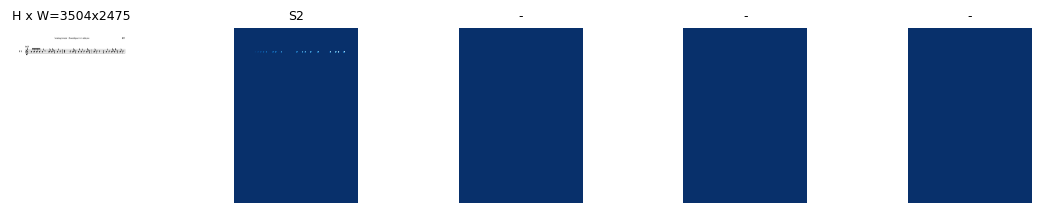

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 1)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

Image path /homes/es314/pitch_Mask_RCNN/only_position/Images/accidentals-002.png not found in dataset.


image_id  525 /homes/es314/pitch_Mask_RCNN/only_position/Images/beam groups 12 demisemiquavers simple-824.png
image                    shape: (3504, 2475, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (3504, 2475, 18)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (18,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (18, 4)               min:  466.00000  max: 2261.00000  int32


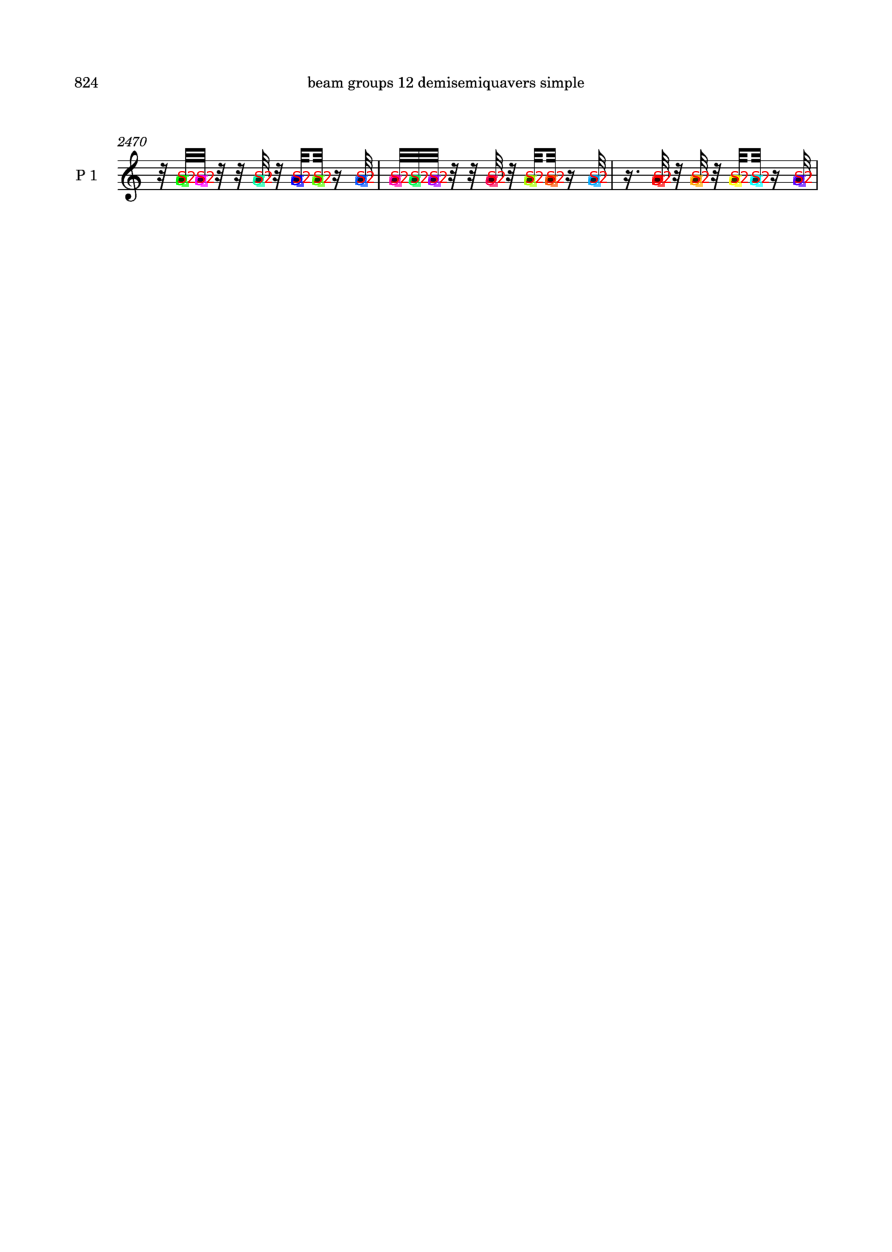

In [79]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [80]:
# Suppose 'image' is your image array
if len(image.shape) == 3:
    if image.shape[2] == 4:
        print("The image has an alpha channel.")
    elif image.shape[2] == 3:
        print("The image is a regular RGB image without an alpha channel.")
else:
    print("The image is grayscale or has an uncommon shape.")


The image is a regular RGB image without an alpha channel.


## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  496 /homes/es314/pitch_Mask_RCNN/only_position/Images/beam groups 12 semiquavers compound-466.png
Original shape:  (3504, 2475, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  uint8
mask                     shape: (1024, 1024, 20)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (20,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (20, 4)               min:  136.00000  max:  798.00000  int32


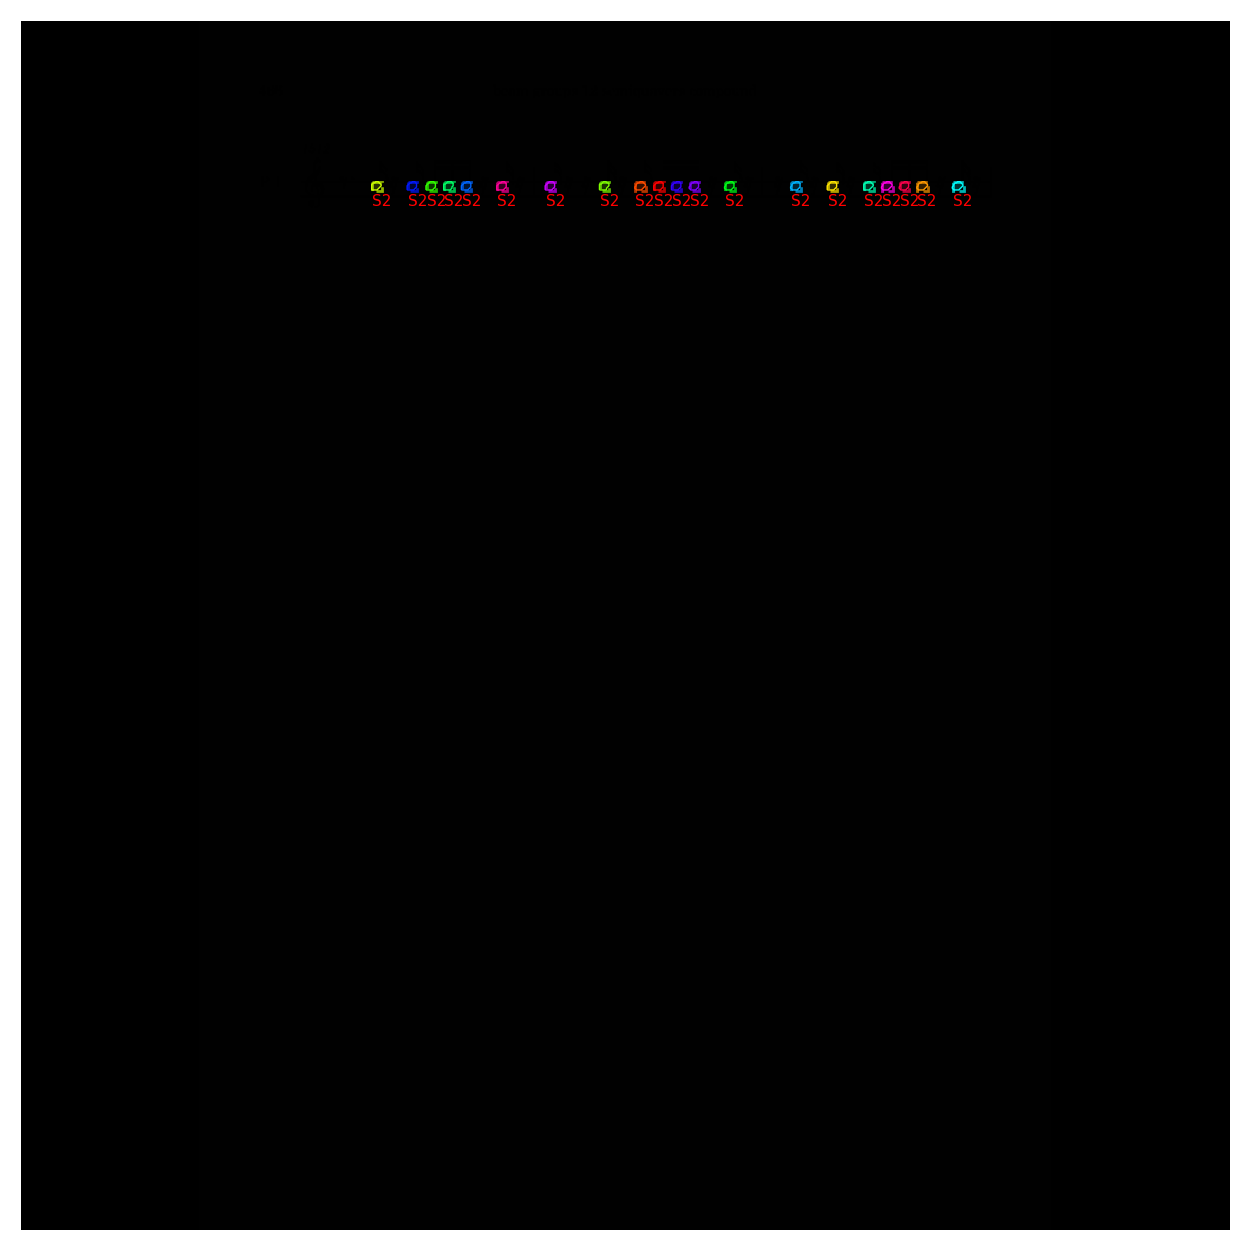

In [81]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  uint8
image_meta               shape: (63,)                 min:    0.00000  max: 3504.00000  float64
class_ids                shape: (18,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (18, 4)               min:  136.00000  max:  796.00000  int32
mask                     shape: (1024, 1024, 18)      min:    0.00000  max:    1.00000  bool


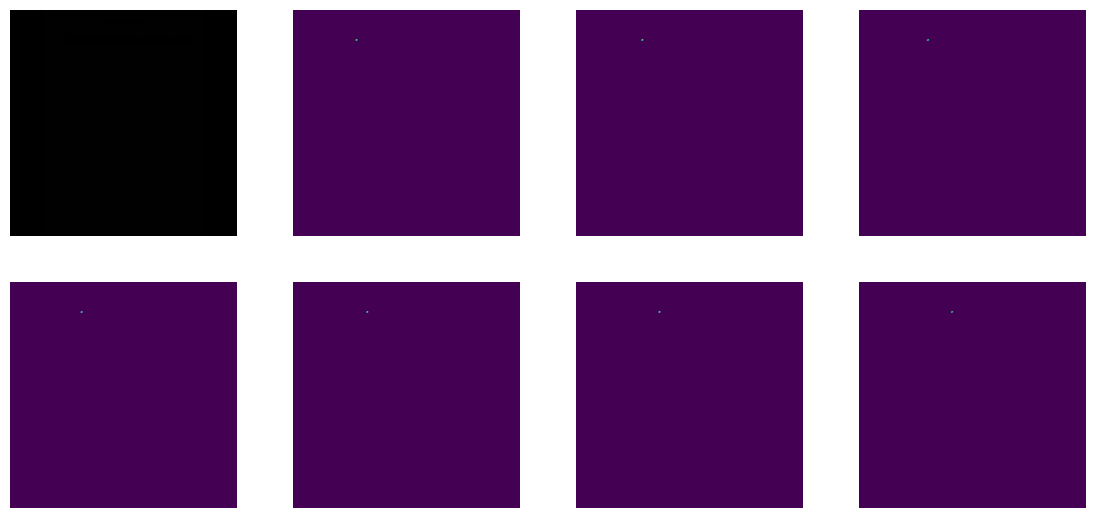

In [13]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

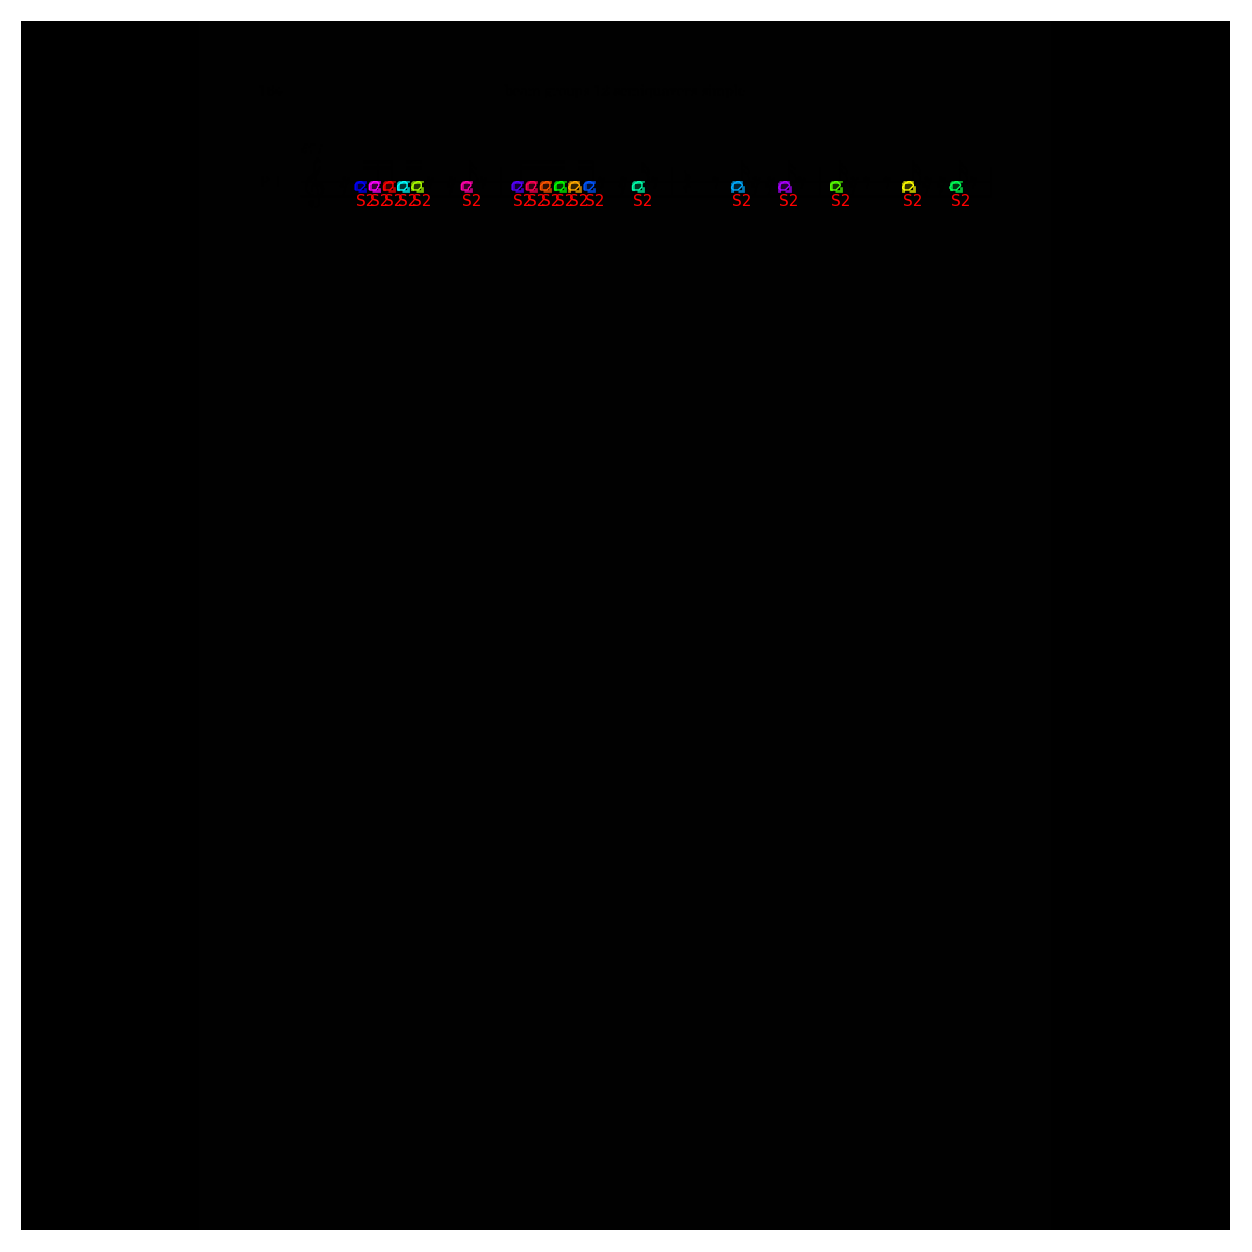

In [14]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (1024, 1024, 18)      min:    0.00000  max:    1.00000  bool


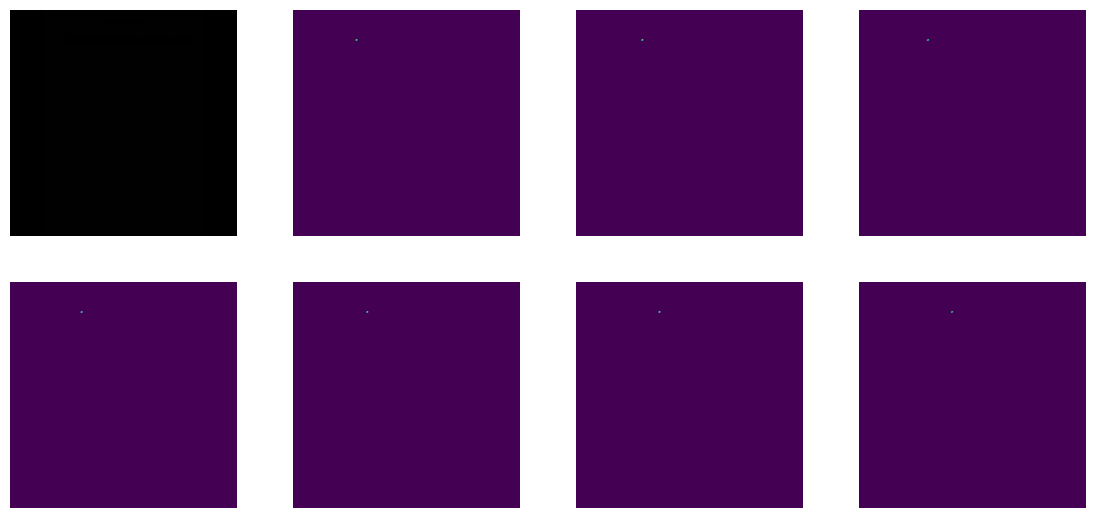

In [15]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

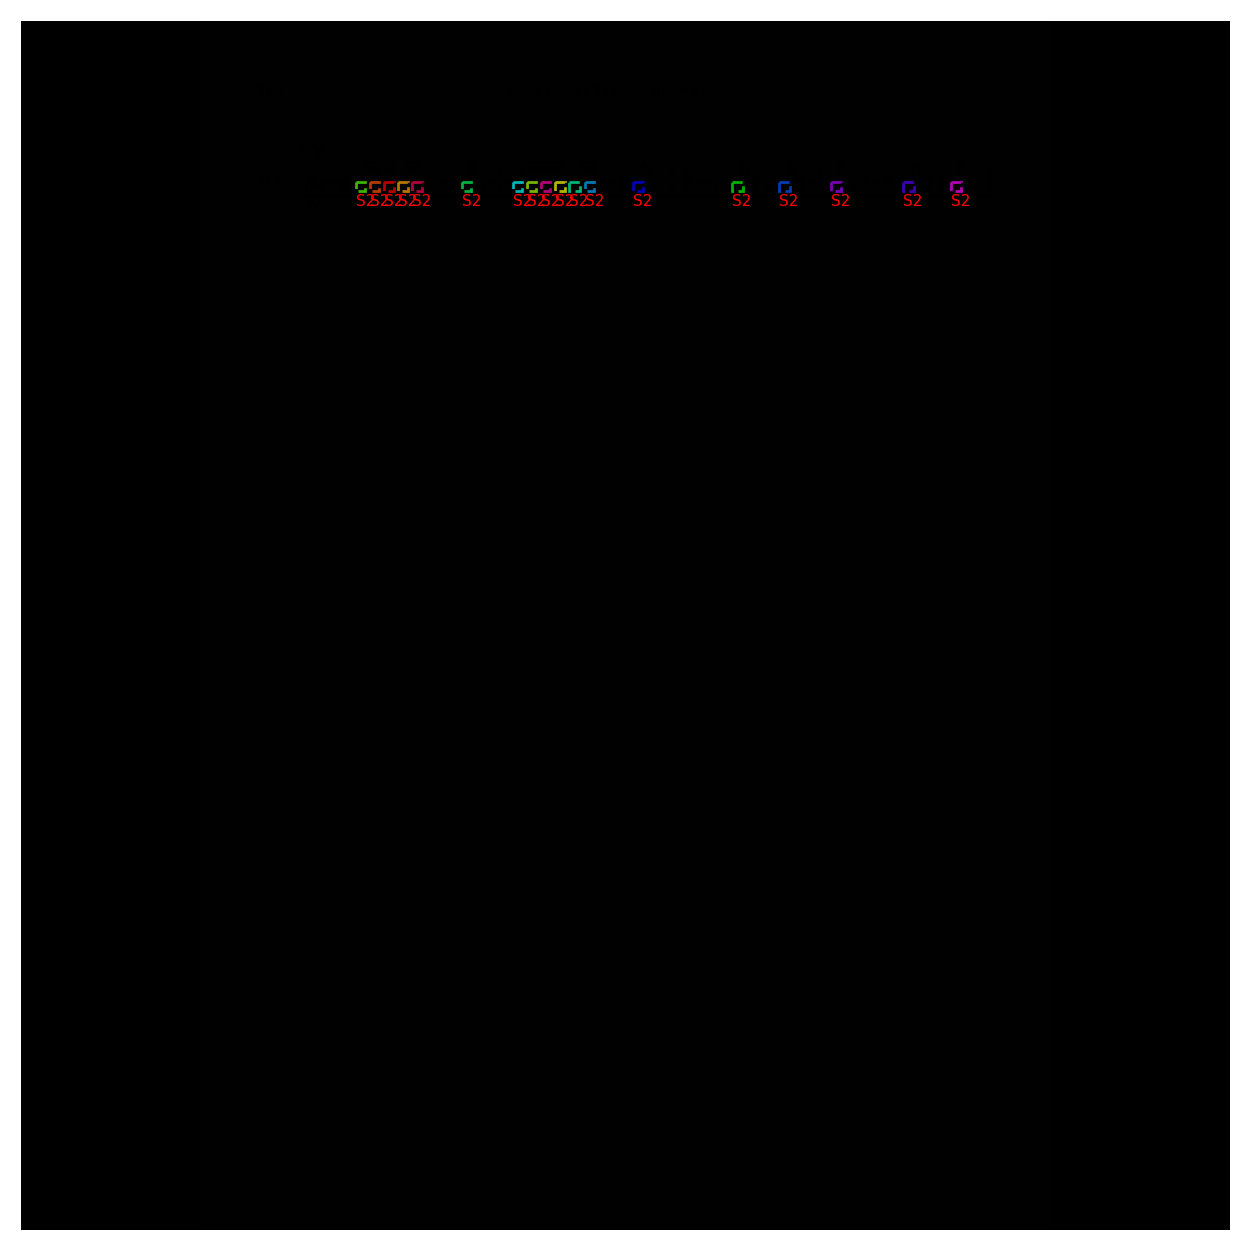

In [16]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [17]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


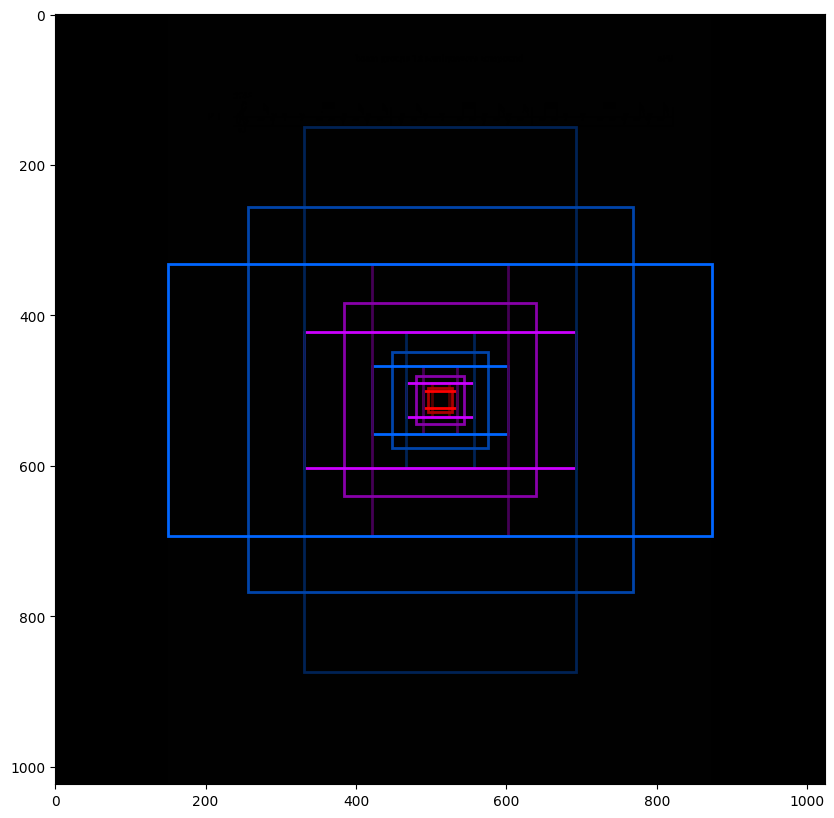

In [18]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [19]:
# Create data generator
random_rois = 100
# https://github.com/matterport/Mask_RCNN/issues/2112
g = modellib.DataGenerator(
    dataset, config, shuffle=True, random_rois=random_rois,
    detection_targets=True)

In [20]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [21]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(iter(g))
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(iter(g))
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (1, 200, 4)           min:    6.00000  max: 1021.00000  int32
mrcnn_class_ids          shape: (1, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (1, 200, 51, 4)       min:   -2.25993  max:    2.00000  float32
mrcnn_mask               shape: (1, 200, 28, 28, 51)  min:    0.00000  max:    0.00000  float32
gt_class_ids             shape: (1, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (1, 100, 4)           min:    0.00000  max:  808.00000  int32
gt_masks                 shape: (1, 1024, 1024, 100)  min:    0.00000  max:    1.00000  bool
rpn_match                shape: (1, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (1, 256, 4)           min:   -9.33200  max:    3.42505  float64
image_id:  1692 /homes/es314/pitch_Mask_RCNN/only_position/Images/beam groups 3-003.png


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (128, 4)              min:  136.00000  max:  808.00000  float32
Positive anchors: 128
Negative anchors: 128
Neutral anchors: 261632
BG                     : 198
S2                     : 2


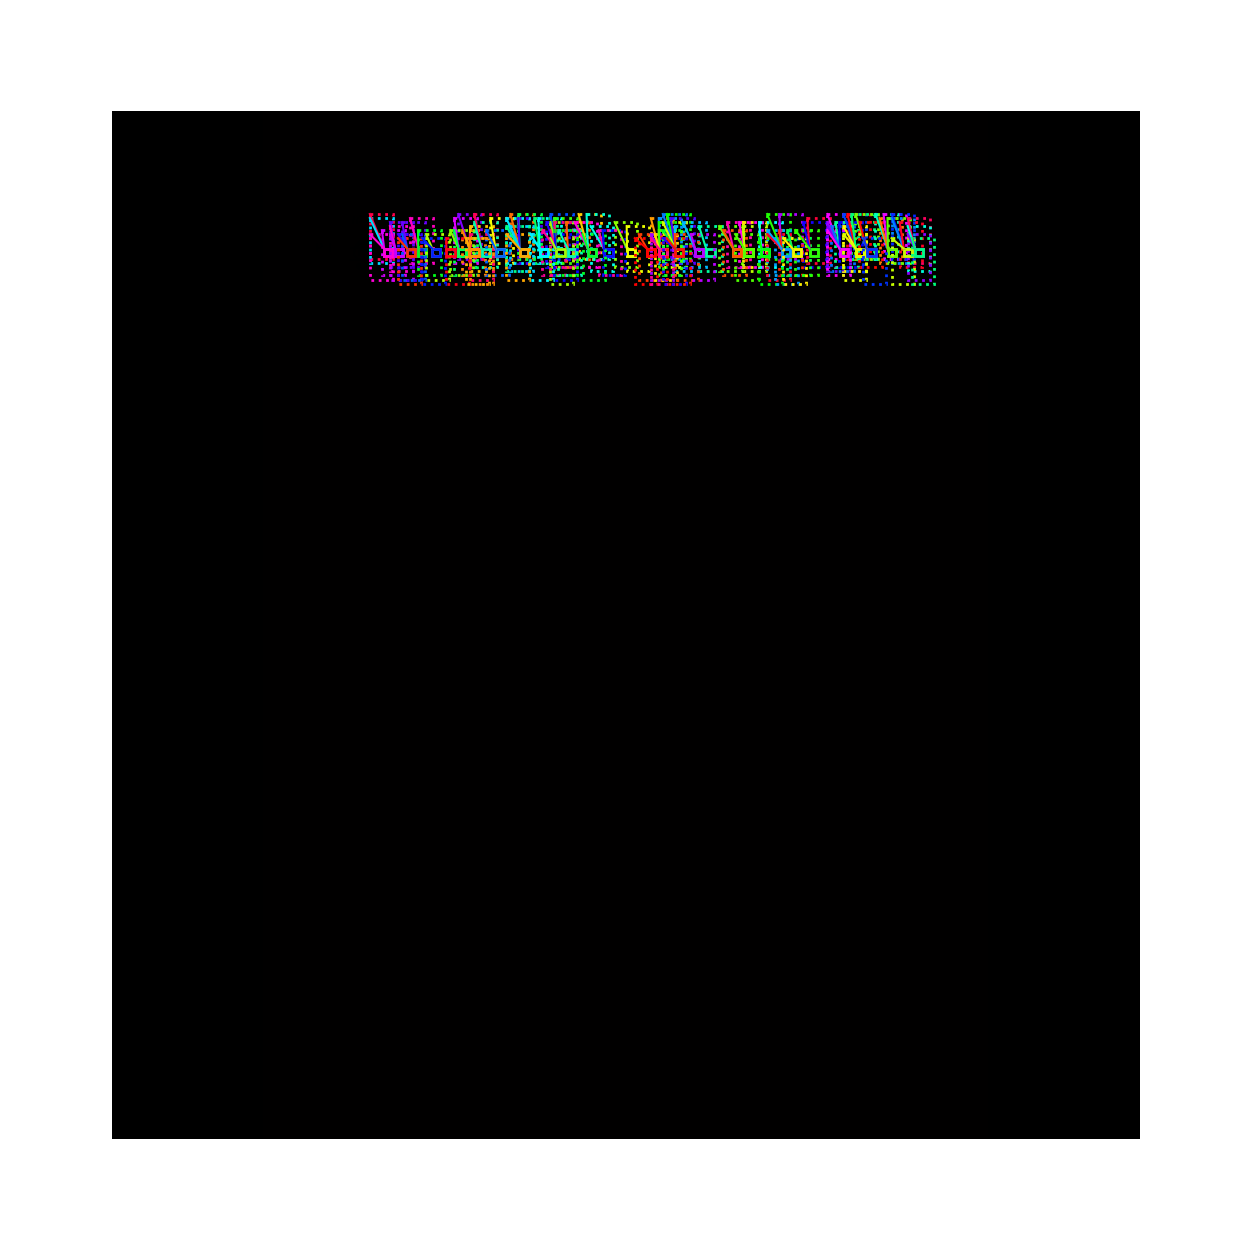

In [22]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

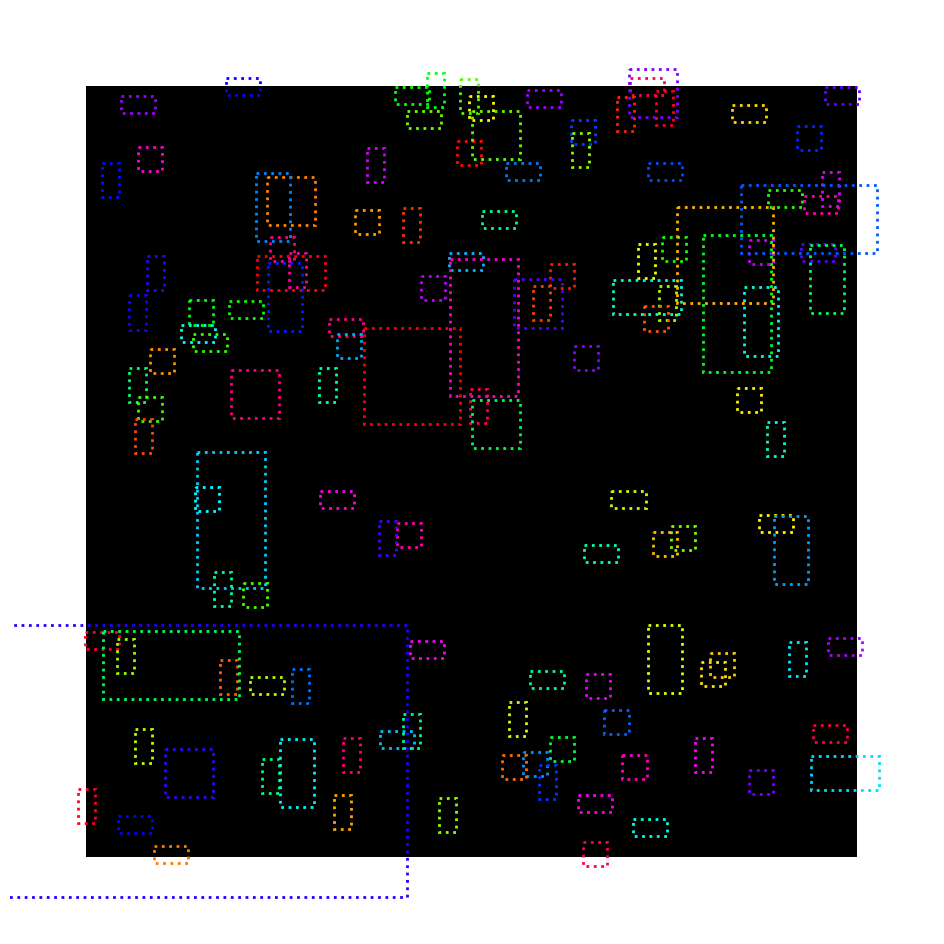

In [23]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

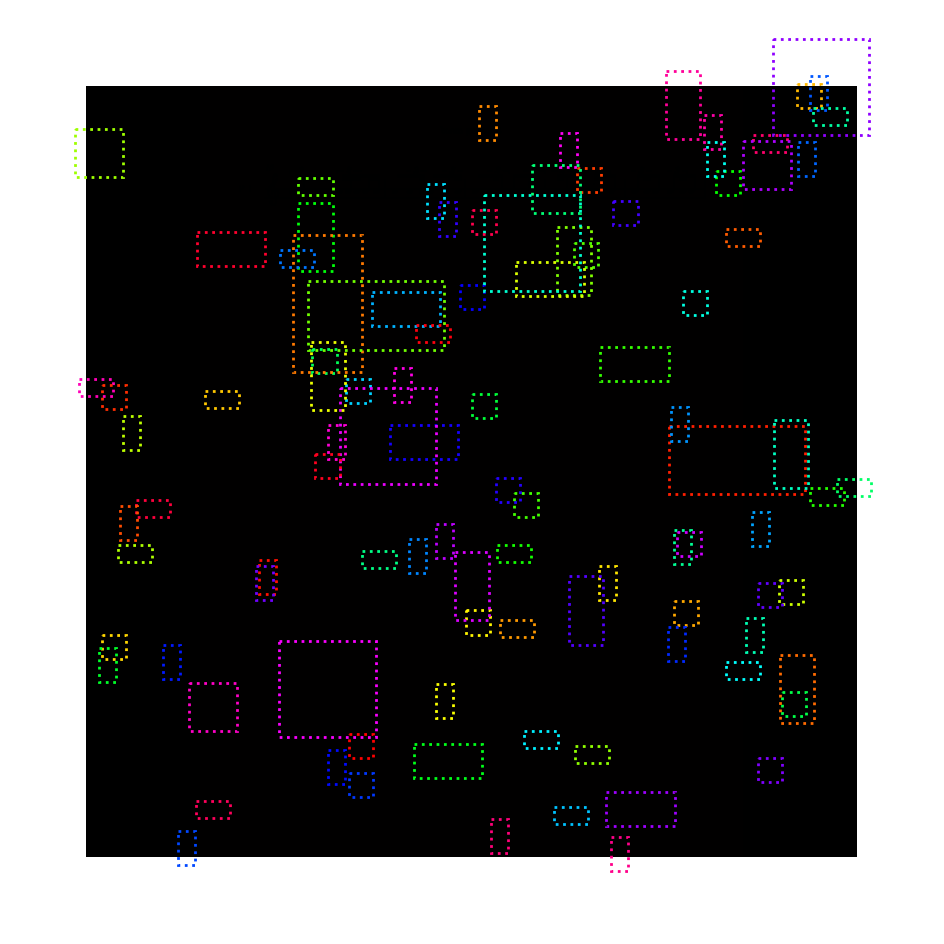

In [24]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  2
Negative ROIs:  198
Positive Ratio: 0.01
Unique ROIs: 100 out of 200


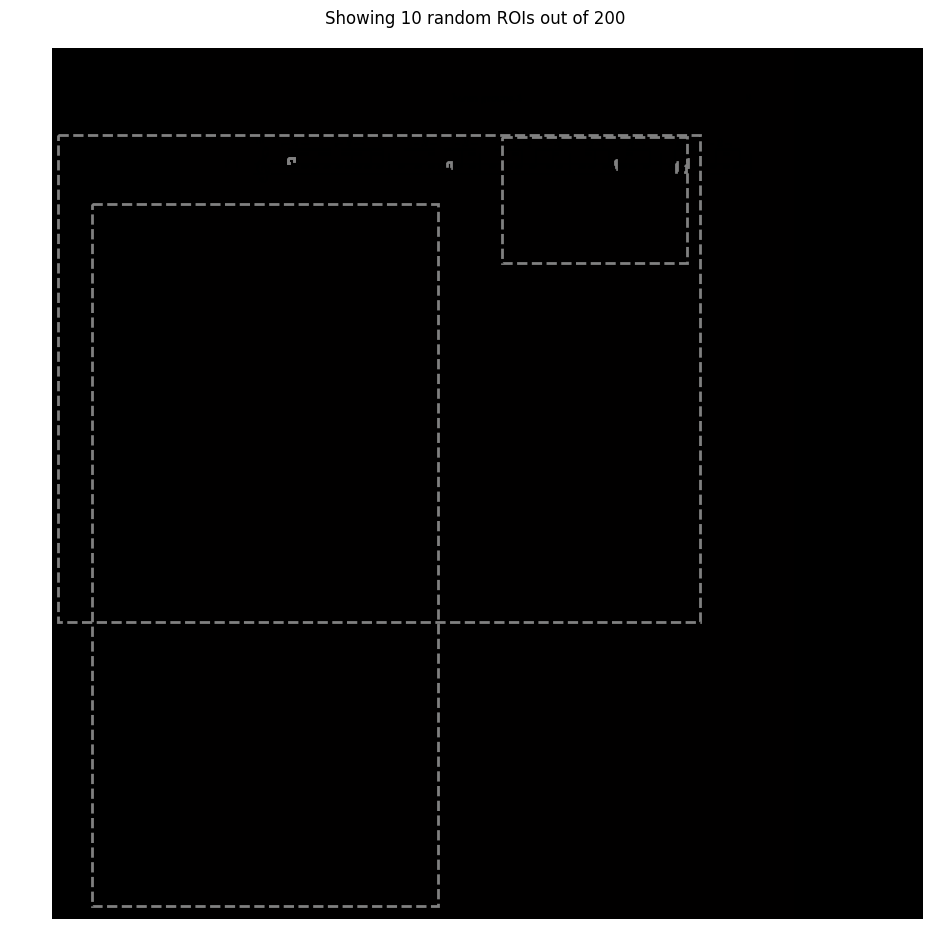

In [25]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

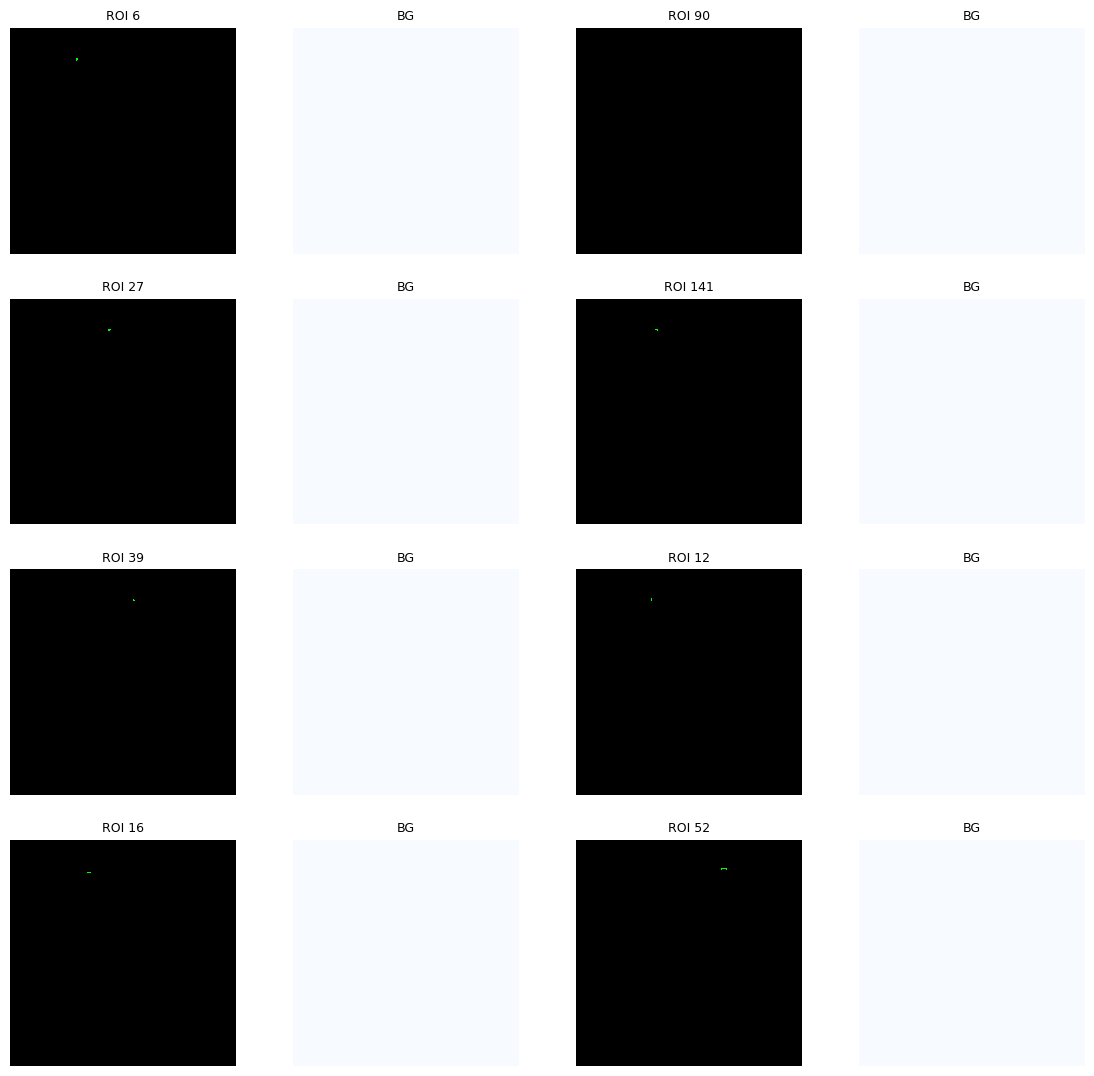

In [26]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [27]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.DataGenerator(
        dataset, config, shuffle=True, random_rois=10000, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(iter(temp_g))
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


In [28]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                63
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0003
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [29]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [30]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [31]:
# Load validation dataset
dataset = DoremiDataset()
dataset.load_doremi("val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

XML Files: 100%|███████████████████████████████████████████████| 569/569 [00:06<00:00, 82.08it/s]

Images: 569
Classes: ['BG', 'S2', 'S9', 'L10', 'L2', 'S-1', 'L6', 'S11', 'L-3', 'S17', 'L15', 'L18', 'S-3', 'S5', 'S-4', 'S18', 'S13', 'S14', 'S10', 'L14', 'L1', 'L-5', 'L4', 'S4', 'L-4', 'S15', 'S0', 'S1', 'L7', 'S7', 'S8', 'L3', 'L9', 'L-1', 'L13', 'L-6', 'L-2', 'S-2', 'L5', 'S-5', 'L8', 'S16', 'S6', 'L0', 'L11', 'S-7', 'L17', 'S3', 'L12', 'L16', 'S12']


In [32]:
MODEL_DIR = '/homes/es314/pitch_Mask_RCNN/logs/doremi20230906T1827'

In [33]:
# Create model in inference mode
import tensorflow as tf
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2023-09-11 18:12:50.693116: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-09-11 18:12:50.767889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:84:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2023-09-11 18:12:50.769950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2023-09-11 18:12:50.771617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2023-09-11 18:12:5

image ID: doremi.beam groups 12 semiquavers simple-1062.png (114) /homes/es314/pitch_Mask_RCNN/only_position/Images/beam groups 12 semiquavers simple-1062.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 63)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


2023-09-11 18:12:52.017394: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-09-11 18:12:52.027599: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3196305000 Hz
2023-09-11 18:12:52.029068: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xceaae70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-11 18:12:52.029112: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-09-11 18:12:52.030492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-09-11 18:12:52.030505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1108]      


gt_class_id              shape: (21,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (21, 4)               min:  136.00000  max:  812.00000  int32
gt_mask                  shape: (1024, 1024, 21)      min:    0.00000  max:    1.00000  bool


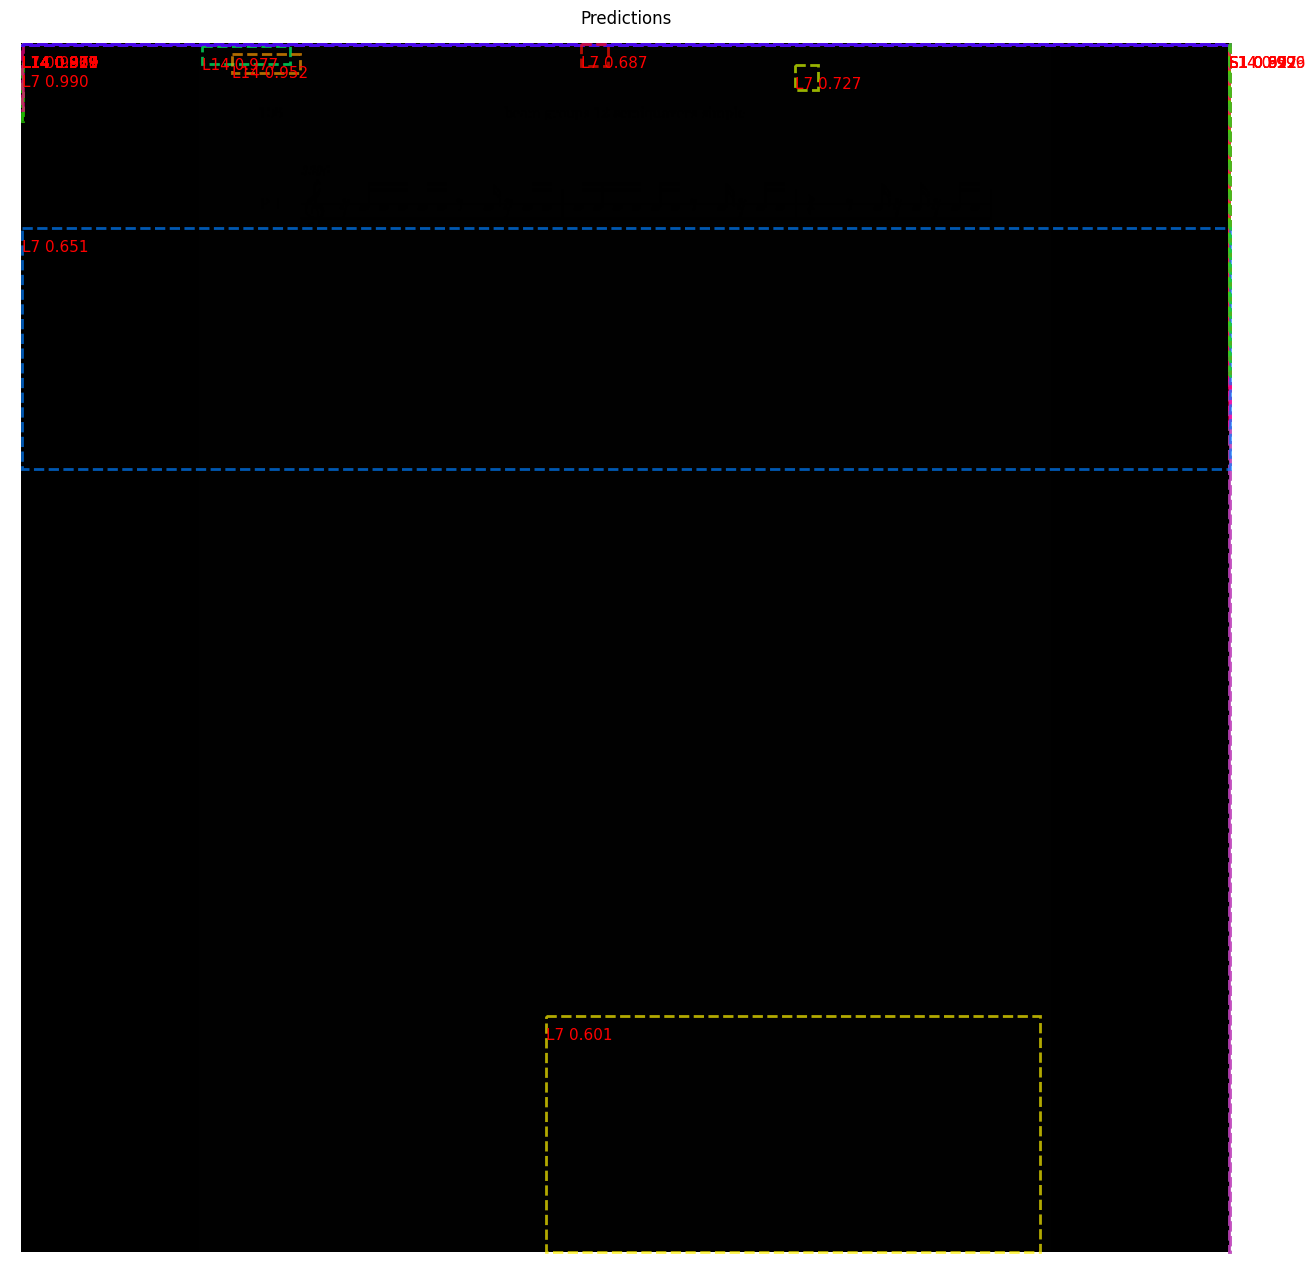

In [34]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

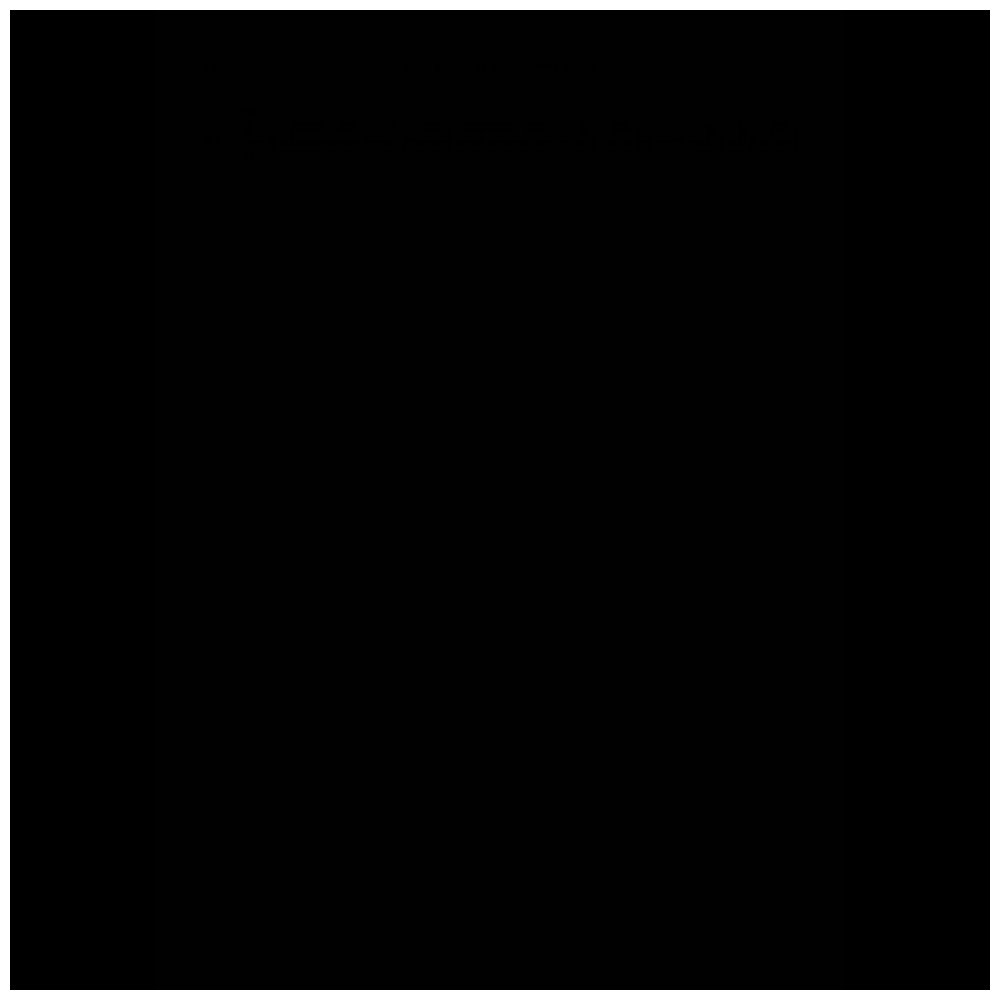

In [35]:
splash = balloon.color_splash(image, r['masks'])
display_images([splash], cols=1)

In [36]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -9.33200  max:    3.42505  float64
positive_anchors         shape: (128, 4)              min:  101.37258  max:  823.31371  float64
negative_anchors         shape: (128, 4)              min:  -32.00000  max: 1141.01934  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (128, 4)              min:  136.00000  max:  812.00000  float32


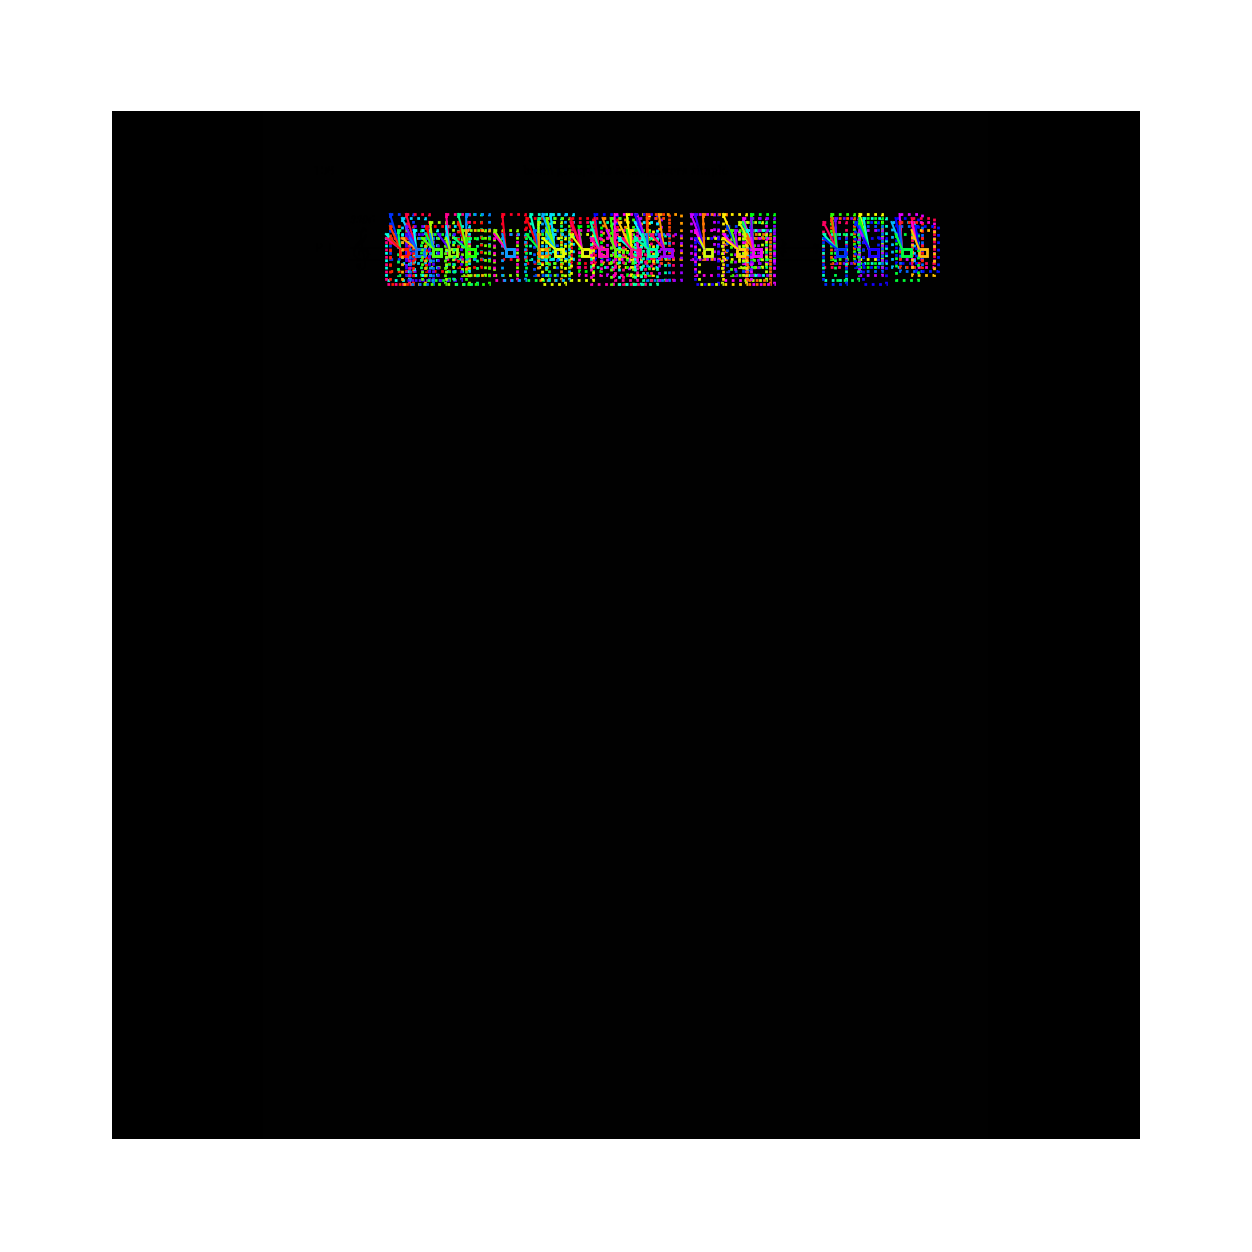

In [37]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

In [38]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.01821  max:    1.01173  float32
refined_anchors          shape: (1, 6000, 4)          min: -126.36415  max:  128.20995  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (31,)                 min:    0.00000  max: 5814.00000  int32
proposals                shape: (1, 100, 4)           min:    0.00000  max:    1.00000  float32


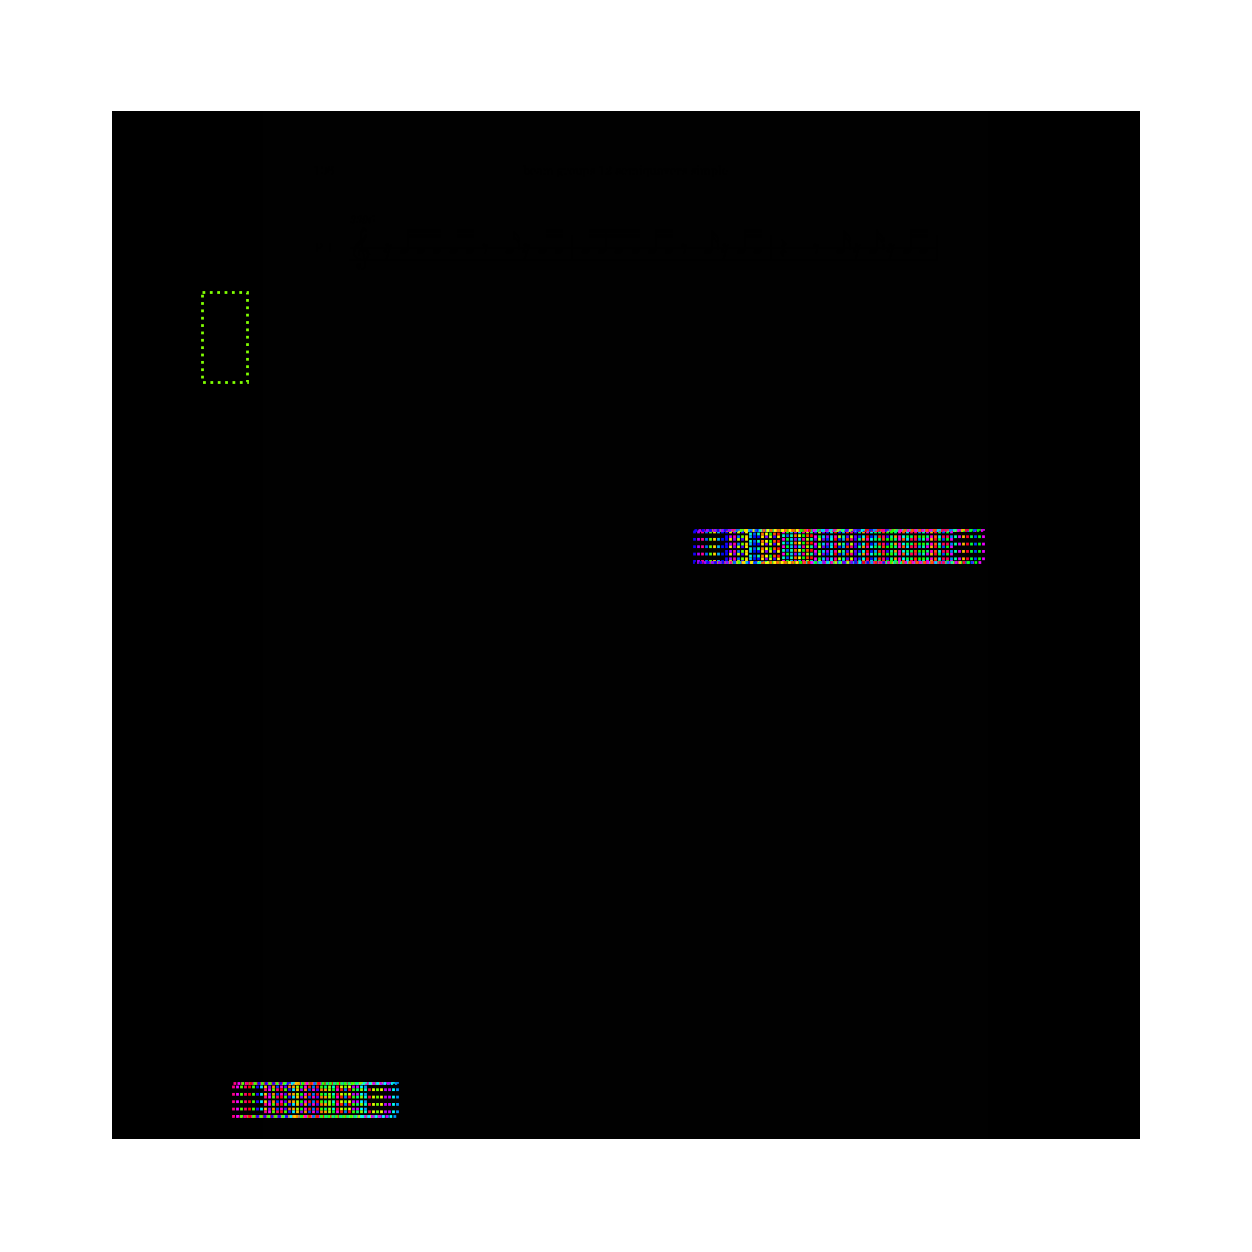

In [39]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

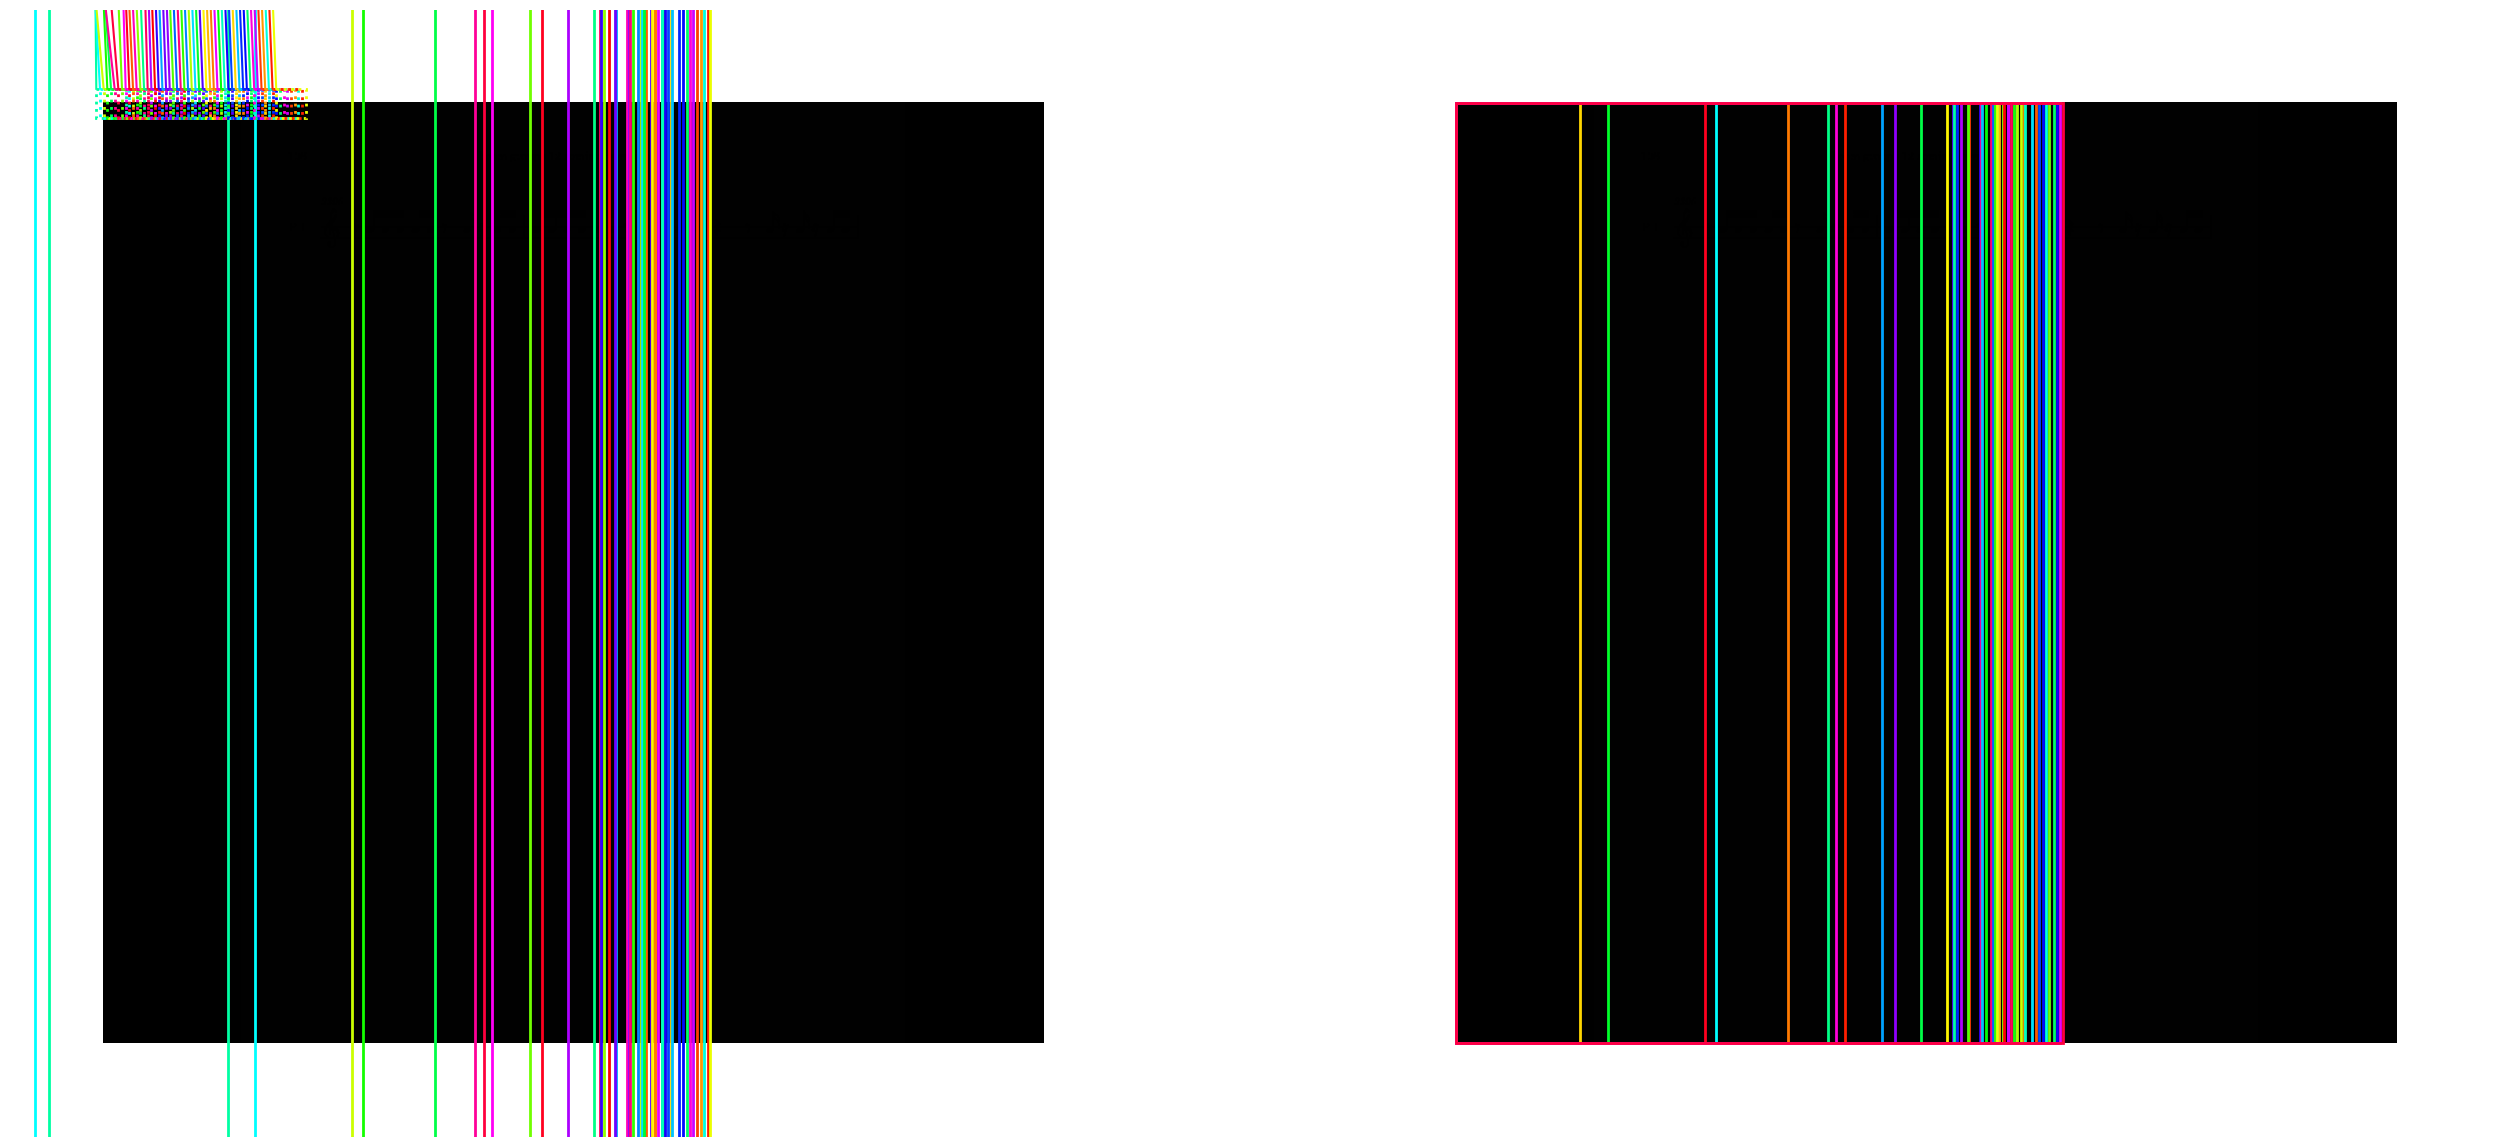

In [40]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

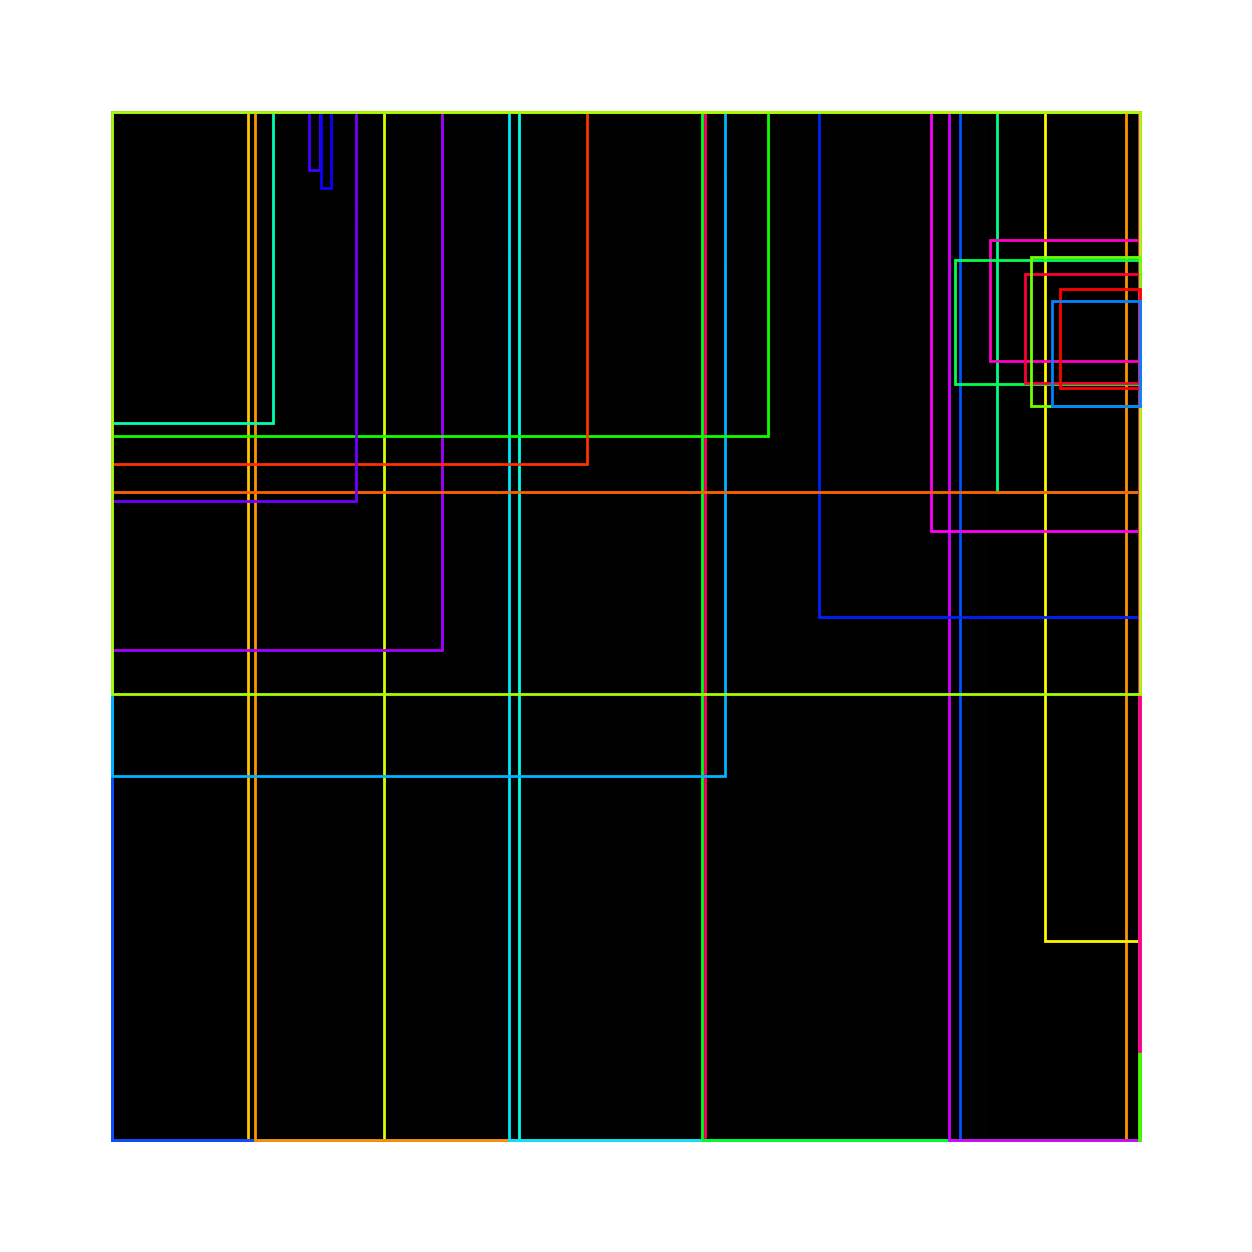

In [41]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

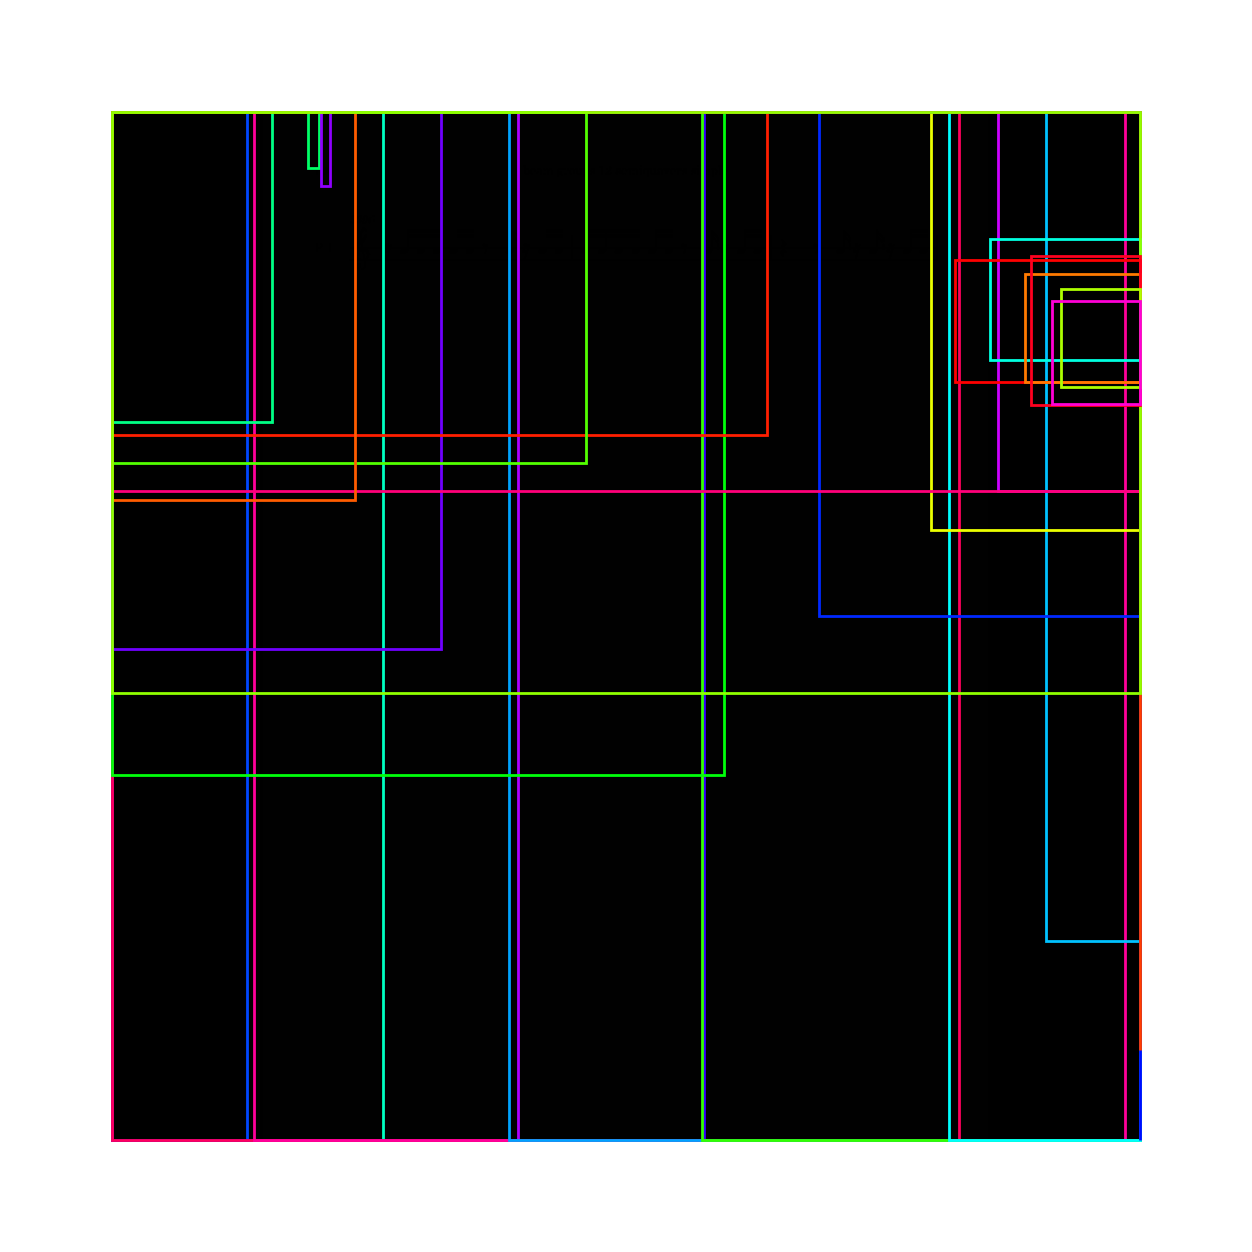

In [42]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [43]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 100, 4)           min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 100, 51)          min:    0.00000  max:    0.99908  float32
deltas                   shape: (1, 100, 51, 4)       min:  -42.92992  max:   46.27935  float32
masks                    shape: (1, 100, 28, 28, 51)  min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:   28.00000  float32


89 detections: ['L14' 'S1' 'L14' 'L7' 'L7' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'S1' 'L14' 'L14' 'S1' 'L14' 'L14' 'S1' 'L14' 'L7' 'L7'
 'S1' 'L7' 'S1' 'L7']


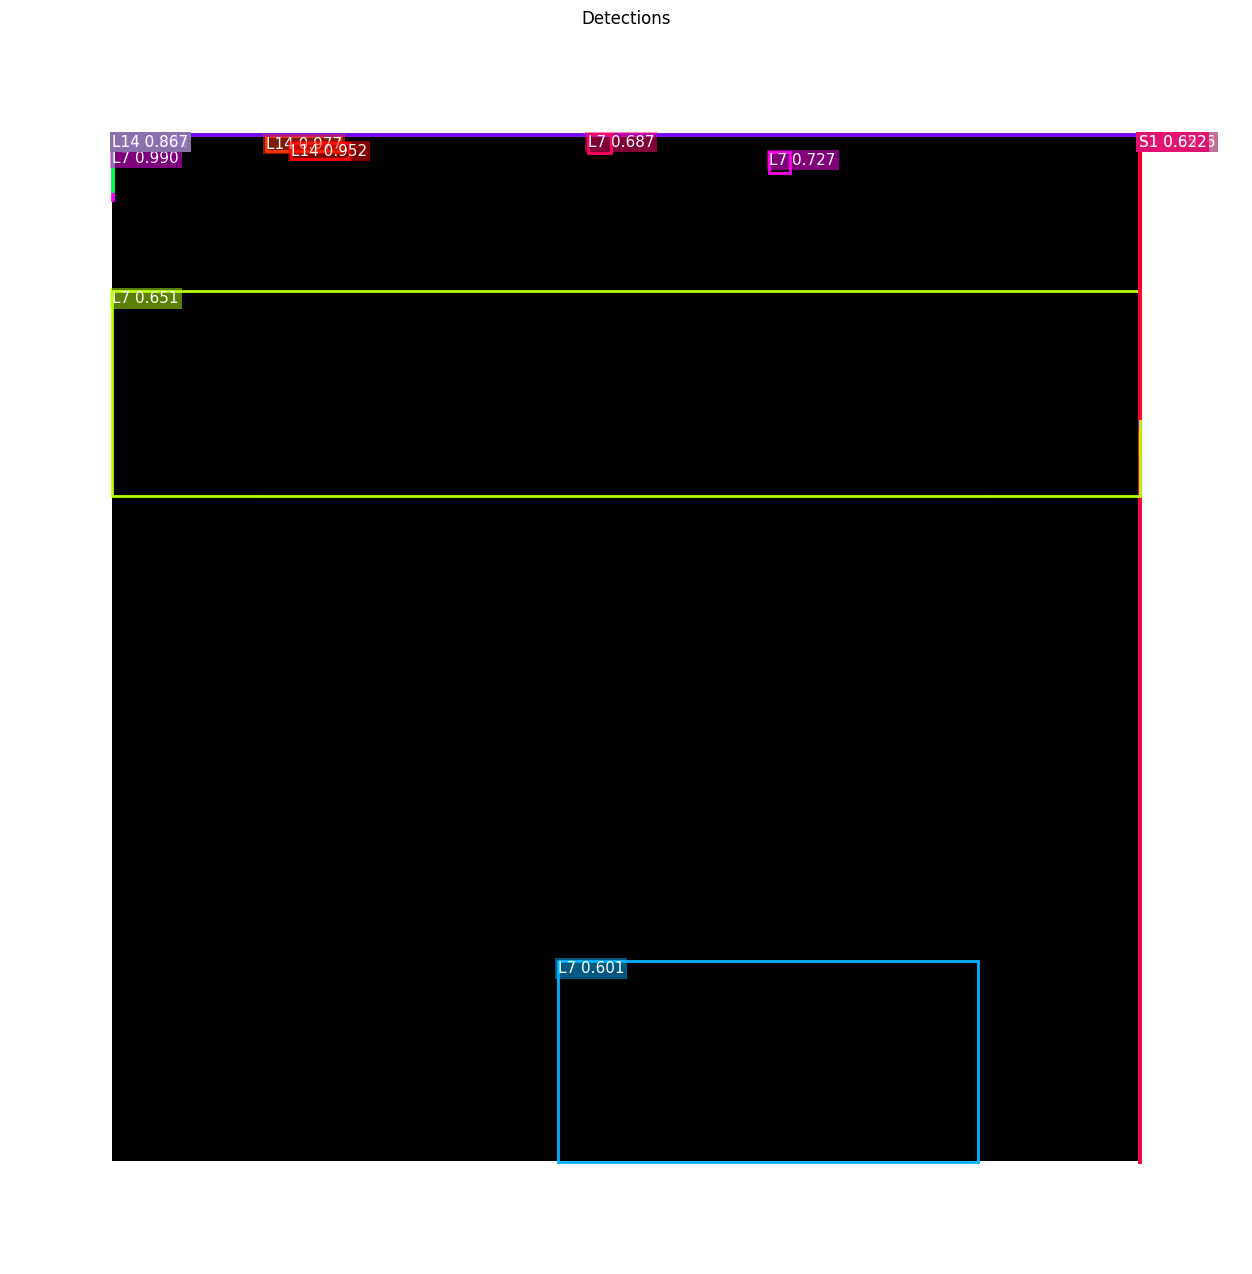

In [44]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [45]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

31 Valid proposals out of 100
100 Positive ROIs
[('L14', 81), ('L7', 12), ('S1', 6), ('S4', 1)]


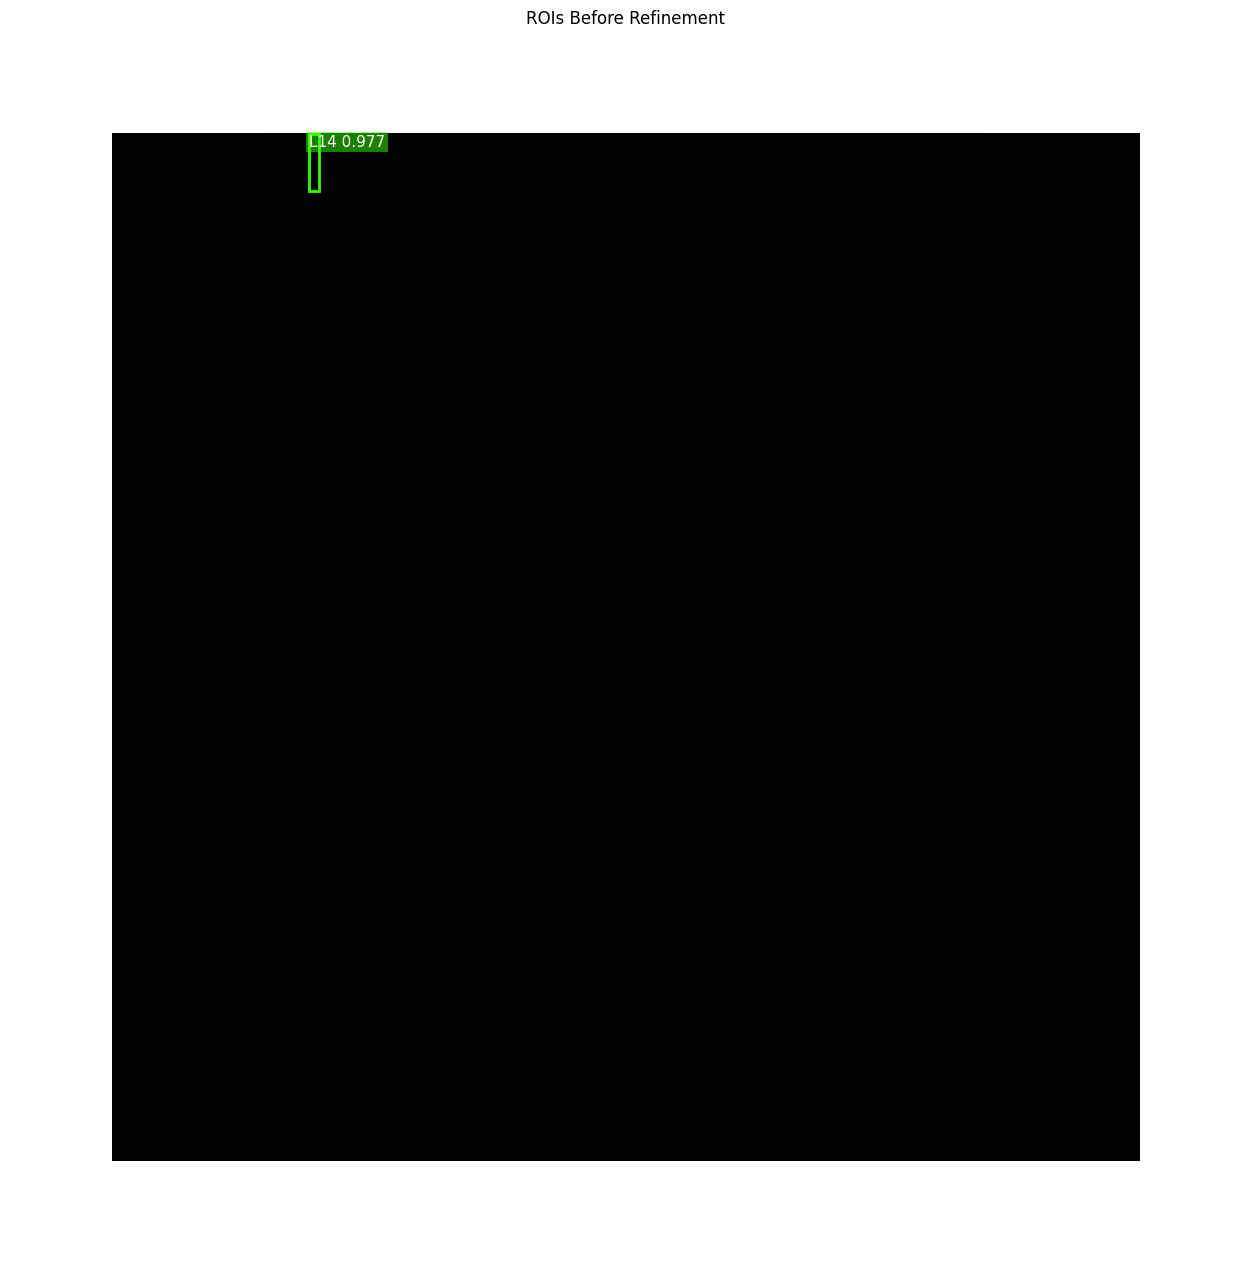

In [46]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 10
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

roi_bbox_specific        shape: (100, 4)              min:  -28.49329  max:   29.87459  float32
refined_proposals        shape: (100, 4)              min: -10295.00000  max: 11002.00000  int32


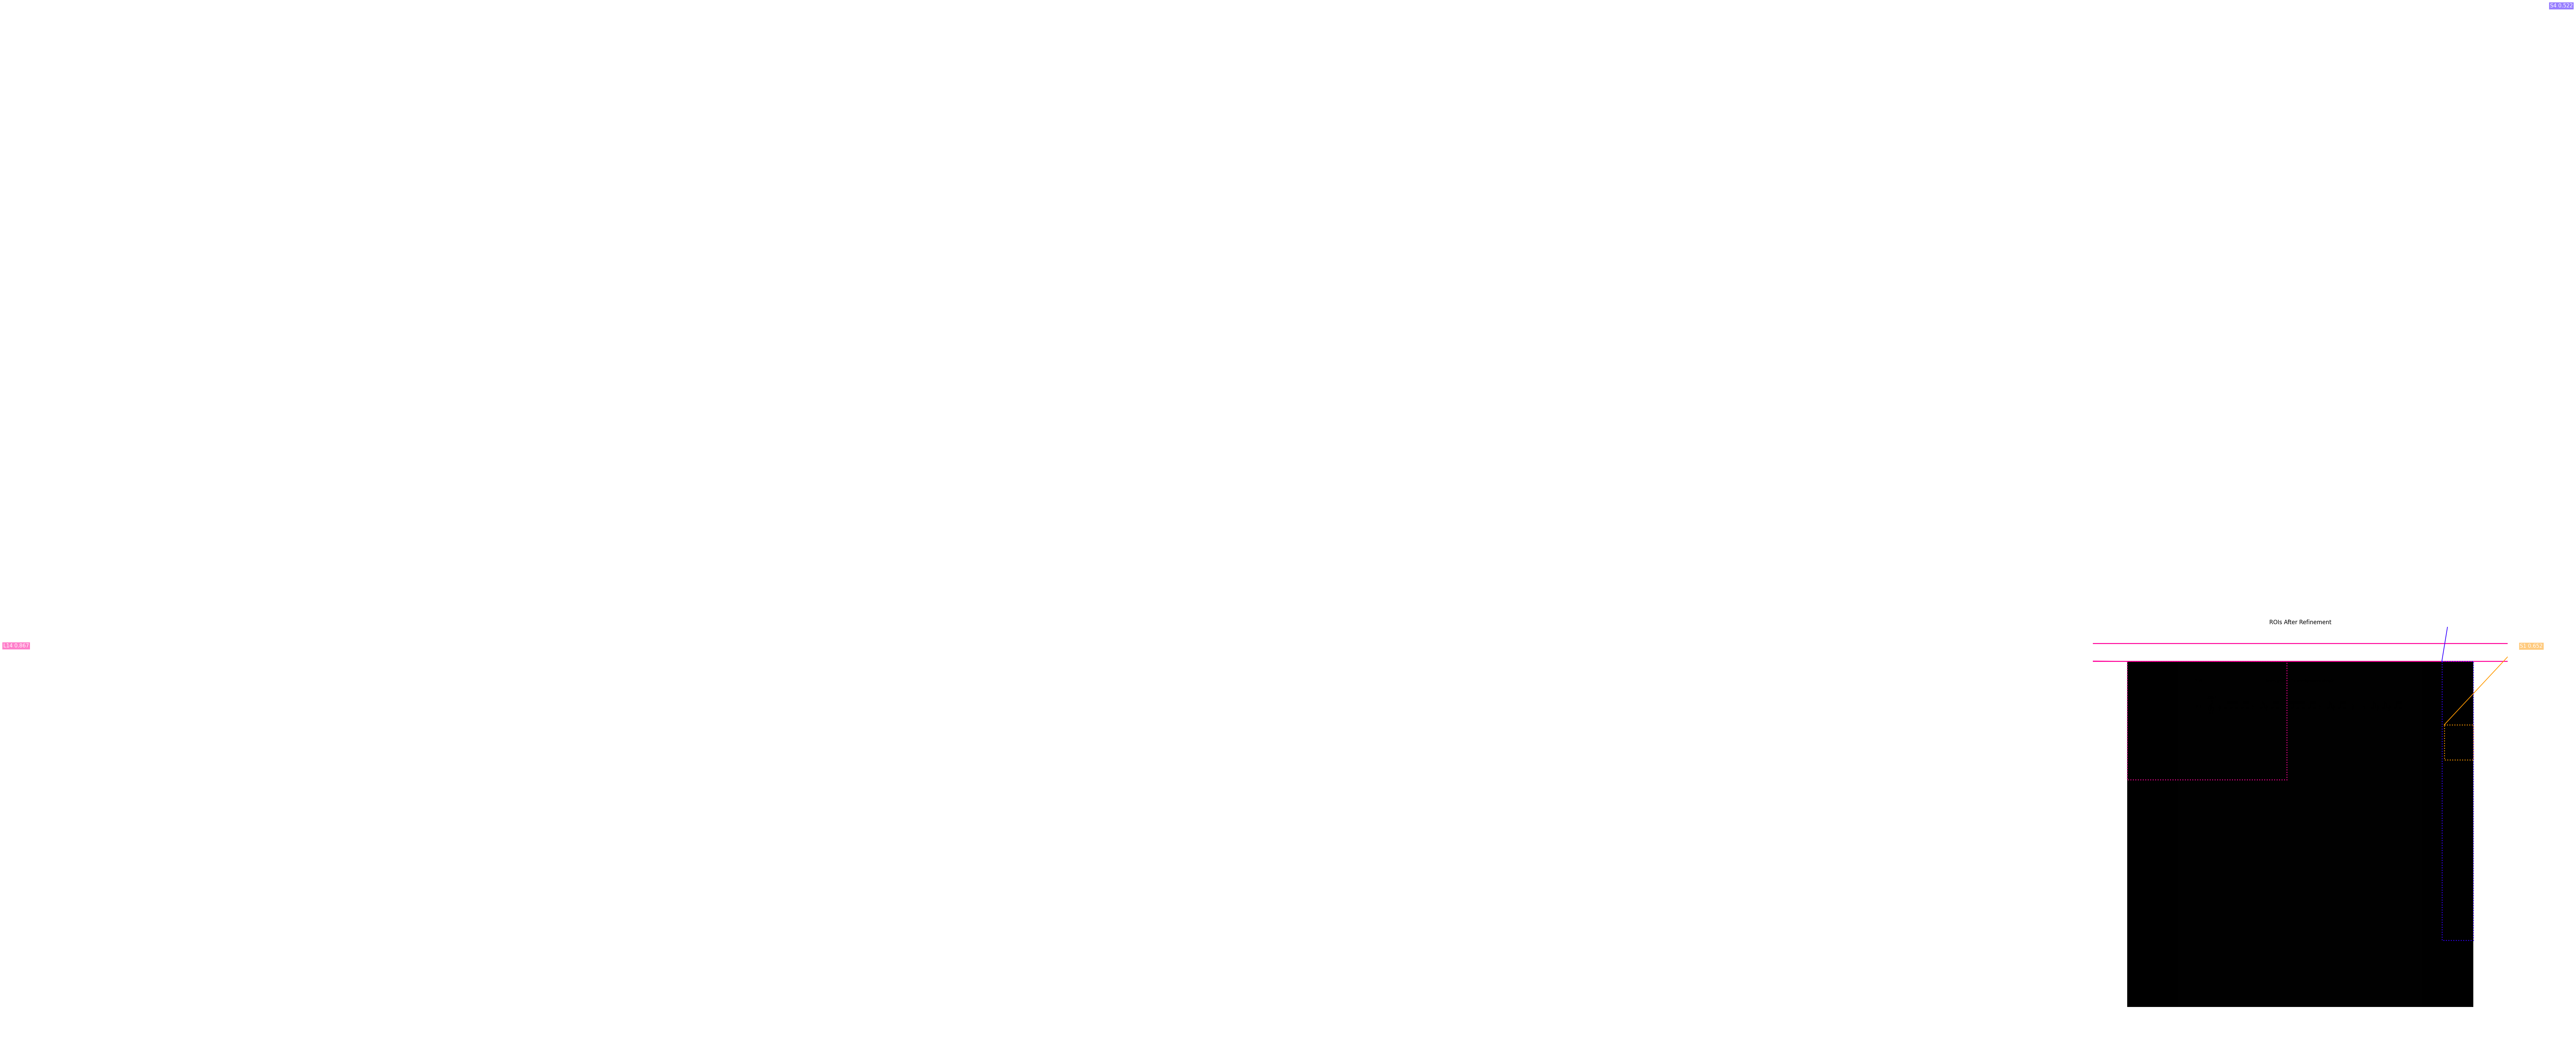

In [47]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 10
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

In [48]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 100 detections:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [49]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.6 confidence. Keep 89:
[ 7 10 11 12 13 15 16 17 18 19 20 21 22 23 24 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82
 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]


In [50]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

L14                   : [10 11 13 15 16 20 22 23 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94
 95 96 97 98 99] -> [22 23 99 54 48 49 50 51 52 53 56 55 46 57 58 59 60 98 47 45 63 44 43 42
 41 40 39 38 37 36 35 34 33 32 31 62 61 64 90 65 85 86 87 88 89 91 82 92
 93 94 95 96 97 83 84 81 72 66 67 68 69 80 71 70 73 74 75 76 77 78 79 10
 13 11 15]
S1                    : [24 26 27 28 29 30] -> [26 24 27 28 30 29]
L7                    : [ 7 12 17 18 19 21] -> [17 21 12 18 19  7]

Kept after per-class NMS: 87
[ 7 10 11 12 13 15 17 18 19 21 22 23 24 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84
 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]


/homes/es314/pitch_Mask_RCNN/mrcnn/utils.py:77: RuntimeWarning: invalid value encountered in true_divide
  iou = intersection / union


In [51]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

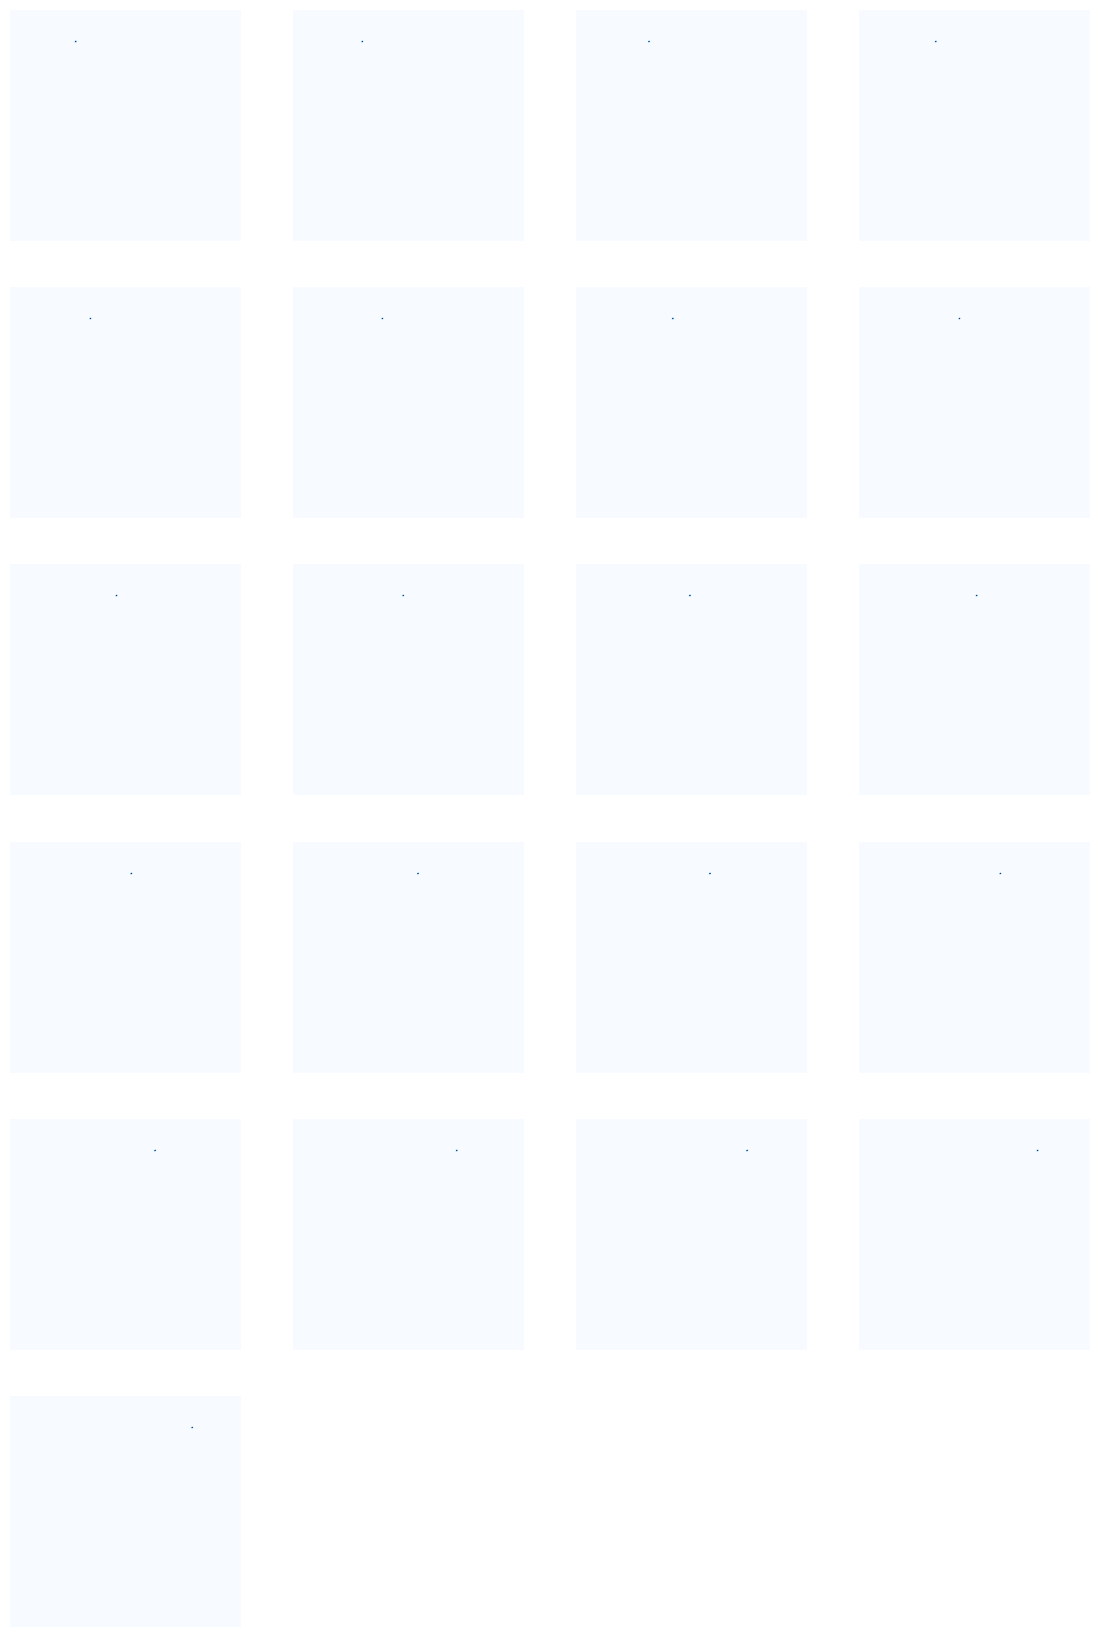

In [52]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

In [53]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:   28.00000  float32
masks                    shape: (1, 100, 28, 28, 51)  min:    0.00000  max:    1.00000  float32
89 detections: ['L14' 'S1' 'L14' 'L7' 'L7' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14' 'L14'
 'L14' 'L14' 'L14' 'S1' 'L14' 'L14' 'S1' 'L14' 'L14' 'S1' 'L14' 'L7' 'L7'
 'S1' 'L7' 'S1' 'L7']


In [54]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (89, 28, 28)          min:    0.00078  max:    0.99970  float32
det_masks                shape: (89, 1024, 1024)      min:    0.00000  max:    0.00000  bool


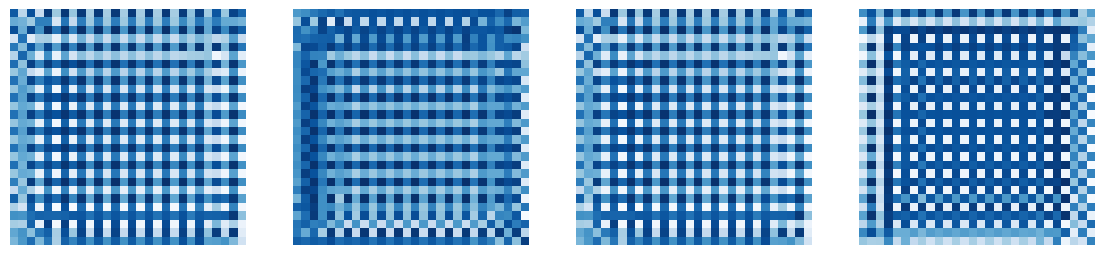

In [55]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

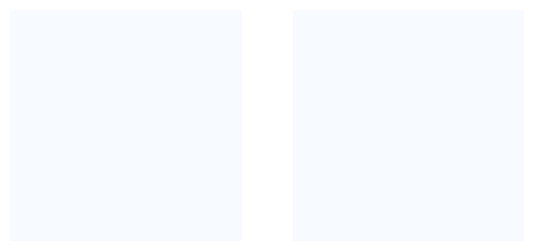

In [56]:
display_images(det_masks[:2] * 255, cmap="Blues", interpolation="none")

In [57]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max: -102.90000  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   66.38273  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   41.55099  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   85.12415  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -67.19048  max:   67.96525  float32
roi                      shape: (1, 100, 4)           min:    0.00000  max:    1.00000  float32


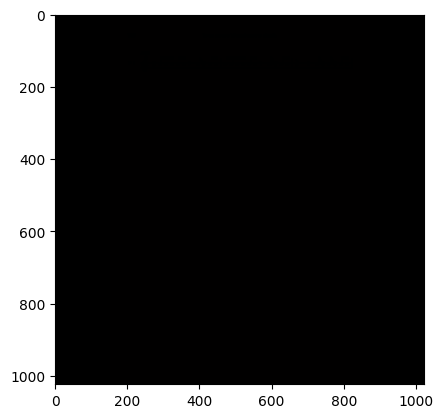

In [58]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

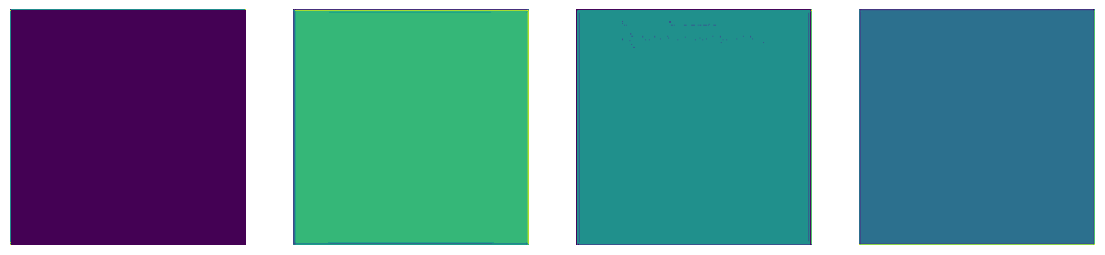

In [59]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)